# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [5]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import os
from torch.utils.data import DataLoader

In [19]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    image_path = "./" + data_dir
        
    train_dataset = datasets.ImageFolder(image_path, transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [22]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

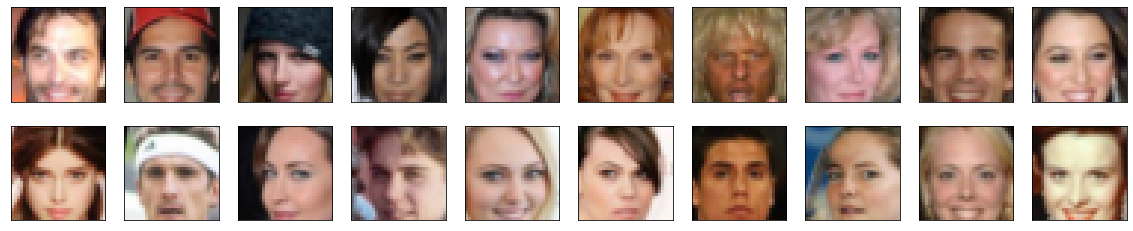

In [23]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [24]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization"""
    layers = []
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                            kernel_size=kernel_size, stride=stride, padding=padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [43]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, batch_norm=False) # x, y = 32, depth 32
        self.conv2 = conv(conv_dim, conv_dim * 2) #(16, 16, 64)
        self.conv3 = conv(conv_dim * 2, conv_dim*4) #(8, 8, 128)
        self.conv4 = conv(conv_dim*4, conv_dim*8) #(4, 4, 256)
        self.conv5 = conv(conv_dim*8, conv_dim*16) #(2, 2, 512)
        
        # Classification layer
        self.classifier = nn.Linear(conv_dim*2*2*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        
        out = out.view(-1, self.conv_dim*2*2*4)
        out = self.classifier(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [44]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization."""
    
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [51]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        # Fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*2*2*4)
        
        # Convolutional layers
        self.t_conv1 = deconv(conv_dim*16, conv_dim*8)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2)
        self.t_conv4 = deconv(conv_dim*2, conv_dim)
        self.t_conv5 = deconv(conv_dim, 3, batch_norm=False)

        self.tanh = nn.Tanh()
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*16, 1, 1) #(batch_size, depth, 2, 2)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        out = F.relu(self.t_conv4(out))
        out = self.t_conv5(out)
        out = self.tanh(out)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [52]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    std_dev = 0.02
    mean = 0.0
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, mean, std_dev)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [54]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=512, out_features

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [56]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) * 0.9
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [57]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [62]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [68]:
# set number of epochs 
n_epochs = 2000


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/ 2000] | d_loss: 0.5149 | g_loss: 2.6630
Epoch [    1/ 2000] | d_loss: 0.7497 | g_loss: 2.0548
Epoch [    1/ 2000] | d_loss: 1.4785 | g_loss: 2.2768
Epoch [    1/ 2000] | d_loss: 0.8579 | g_loss: 2.1141
Epoch [    1/ 2000] | d_loss: 0.4786 | g_loss: 2.1666
Epoch [    1/ 2000] | d_loss: 0.9374 | g_loss: 2.0515
Epoch [    1/ 2000] | d_loss: 0.6861 | g_loss: 2.4635
Epoch [    1/ 2000] | d_loss: 0.5568 | g_loss: 2.8404
Epoch [    1/ 2000] | d_loss: 1.1998 | g_loss: 2.3251
Epoch [    1/ 2000] | d_loss: 0.8539 | g_loss: 1.6729
Epoch [    1/ 2000] | d_loss: 1.6520 | g_loss: 1.3915
Epoch [    1/ 2000] | d_loss: 0.8126 | g_loss: 1.9306
Epoch [    1/ 2000] | d_loss: 0.7159 | g_loss: 2.3703
Epoch [    1/ 2000] | d_loss: 0.6412 | g_loss: 2.3211
Epoch [    1/ 2000] | d_loss: 0.5805 | g_loss: 1.6862
Epoch [    1/ 2000] | d_loss: 0.8238 | g_loss: 3.0581
Epoch [    2/ 2000] | d_loss: 1.8302 | g_loss: 3.3648
Epoch [    2/ 2000] | d_loss: 0.6754 | g_loss: 1.5769
Epoch [    2/ 2000] | d_loss

Epoch [   10/ 2000] | d_loss: 0.8101 | g_loss: 2.8647
Epoch [   10/ 2000] | d_loss: 0.5628 | g_loss: 3.1094
Epoch [   10/ 2000] | d_loss: 0.7102 | g_loss: 2.7483
Epoch [   10/ 2000] | d_loss: 0.6995 | g_loss: 1.6831
Epoch [   10/ 2000] | d_loss: 0.3820 | g_loss: 4.0460
Epoch [   10/ 2000] | d_loss: 0.9677 | g_loss: 3.7427
Epoch [   10/ 2000] | d_loss: 0.6708 | g_loss: 1.5596
Epoch [   10/ 2000] | d_loss: 0.6318 | g_loss: 2.6877
Epoch [   11/ 2000] | d_loss: 1.1960 | g_loss: 2.0328
Epoch [   11/ 2000] | d_loss: 0.6968 | g_loss: 1.9827
Epoch [   11/ 2000] | d_loss: 1.2992 | g_loss: 2.4123
Epoch [   11/ 2000] | d_loss: 0.5408 | g_loss: 1.8092
Epoch [   11/ 2000] | d_loss: 0.7621 | g_loss: 2.2223
Epoch [   11/ 2000] | d_loss: 0.5640 | g_loss: 1.3211
Epoch [   11/ 2000] | d_loss: 1.3585 | g_loss: 2.3967
Epoch [   11/ 2000] | d_loss: 0.6122 | g_loss: 1.9469
Epoch [   11/ 2000] | d_loss: 0.4632 | g_loss: 2.2735
Epoch [   11/ 2000] | d_loss: 0.8751 | g_loss: 3.3426
Epoch [   11/ 2000] | d_loss

Epoch [   20/ 2000] | d_loss: 0.4411 | g_loss: 3.7736
Epoch [   20/ 2000] | d_loss: 0.4236 | g_loss: 3.7242
Epoch [   20/ 2000] | d_loss: 1.0125 | g_loss: 4.2996
Epoch [   20/ 2000] | d_loss: 0.5507 | g_loss: 1.8862
Epoch [   20/ 2000] | d_loss: 0.8861 | g_loss: 2.3681
Epoch [   20/ 2000] | d_loss: 0.4414 | g_loss: 3.7704
Epoch [   20/ 2000] | d_loss: 0.4465 | g_loss: 2.6746
Epoch [   20/ 2000] | d_loss: 0.8747 | g_loss: 2.1269
Epoch [   20/ 2000] | d_loss: 1.1214 | g_loss: 1.7917
Epoch [   20/ 2000] | d_loss: 0.5144 | g_loss: 2.2982
Epoch [   20/ 2000] | d_loss: 0.6748 | g_loss: 1.7827
Epoch [   20/ 2000] | d_loss: 0.6088 | g_loss: 1.8834
Epoch [   20/ 2000] | d_loss: 0.4024 | g_loss: 3.8279
Epoch [   20/ 2000] | d_loss: 0.6270 | g_loss: 3.6160
Epoch [   20/ 2000] | d_loss: 0.7663 | g_loss: 3.2180
Epoch [   20/ 2000] | d_loss: 0.6262 | g_loss: 1.7016
Epoch [   21/ 2000] | d_loss: 0.6483 | g_loss: 1.7897
Epoch [   21/ 2000] | d_loss: 0.6162 | g_loss: 2.9602
Epoch [   21/ 2000] | d_loss

Epoch [   29/ 2000] | d_loss: 0.3728 | g_loss: 4.2267
Epoch [   29/ 2000] | d_loss: 0.3757 | g_loss: 4.9273
Epoch [   29/ 2000] | d_loss: 0.3589 | g_loss: 4.1967
Epoch [   29/ 2000] | d_loss: 0.3621 | g_loss: 4.6213
Epoch [   29/ 2000] | d_loss: 0.3602 | g_loss: 6.7034
Epoch [   29/ 2000] | d_loss: 0.3418 | g_loss: 4.7023
Epoch [   29/ 2000] | d_loss: 0.3472 | g_loss: 4.3579
Epoch [   29/ 2000] | d_loss: 0.3493 | g_loss: 4.9459
Epoch [   30/ 2000] | d_loss: 0.3641 | g_loss: 5.1837
Epoch [   30/ 2000] | d_loss: 0.3627 | g_loss: 6.8942
Epoch [   30/ 2000] | d_loss: 0.3432 | g_loss: 5.2138
Epoch [   30/ 2000] | d_loss: 0.3521 | g_loss: 4.9383
Epoch [   30/ 2000] | d_loss: 0.3634 | g_loss: 5.6823
Epoch [   30/ 2000] | d_loss: 0.3541 | g_loss: 5.5729
Epoch [   30/ 2000] | d_loss: 0.3495 | g_loss: 4.9564
Epoch [   30/ 2000] | d_loss: 0.3939 | g_loss: 7.7651
Epoch [   30/ 2000] | d_loss: 0.4425 | g_loss: 4.2120
Epoch [   30/ 2000] | d_loss: 0.3530 | g_loss: 4.3227
Epoch [   30/ 2000] | d_loss

Epoch [   39/ 2000] | d_loss: 0.3392 | g_loss: 5.7201
Epoch [   39/ 2000] | d_loss: 0.3598 | g_loss: 7.4375
Epoch [   39/ 2000] | d_loss: 0.3314 | g_loss: 6.9965
Epoch [   39/ 2000] | d_loss: 0.3329 | g_loss: 5.9910
Epoch [   39/ 2000] | d_loss: 0.3363 | g_loss: 6.7397
Epoch [   39/ 2000] | d_loss: 0.3947 | g_loss: 4.9054
Epoch [   39/ 2000] | d_loss: 0.3447 | g_loss: 5.6010
Epoch [   39/ 2000] | d_loss: 0.3990 | g_loss: 6.2695
Epoch [   39/ 2000] | d_loss: 0.3429 | g_loss: 6.5775
Epoch [   39/ 2000] | d_loss: 0.3303 | g_loss: 5.5322
Epoch [   39/ 2000] | d_loss: 0.3403 | g_loss: 6.2581
Epoch [   39/ 2000] | d_loss: 0.3317 | g_loss: 6.2497
Epoch [   39/ 2000] | d_loss: 0.3374 | g_loss: 5.5562
Epoch [   39/ 2000] | d_loss: 0.3317 | g_loss: 6.2700
Epoch [   39/ 2000] | d_loss: 0.3415 | g_loss: 5.9126
Epoch [   39/ 2000] | d_loss: 0.3396 | g_loss: 5.6945
Epoch [   40/ 2000] | d_loss: 0.8247 | g_loss: 5.4313
Epoch [   40/ 2000] | d_loss: 0.3310 | g_loss: 6.1745
Epoch [   40/ 2000] | d_loss

Epoch [   48/ 2000] | d_loss: 0.3302 | g_loss: 8.7343
Epoch [   48/ 2000] | d_loss: 0.3304 | g_loss: 7.1370
Epoch [   48/ 2000] | d_loss: 0.3359 | g_loss: 7.0654
Epoch [   48/ 2000] | d_loss: 0.3322 | g_loss: 6.8963
Epoch [   48/ 2000] | d_loss: 0.3305 | g_loss: 5.7579
Epoch [   48/ 2000] | d_loss: 0.3361 | g_loss: 7.0289
Epoch [   48/ 2000] | d_loss: 0.3334 | g_loss: 6.9480
Epoch [   48/ 2000] | d_loss: 0.3275 | g_loss: 7.7645
Epoch [   49/ 2000] | d_loss: 0.3318 | g_loss: 7.1009
Epoch [   49/ 2000] | d_loss: 0.3330 | g_loss: 7.5355
Epoch [   49/ 2000] | d_loss: 0.3276 | g_loss: 6.4394
Epoch [   49/ 2000] | d_loss: 0.3285 | g_loss: 6.8923
Epoch [   49/ 2000] | d_loss: 0.3279 | g_loss: 7.0846
Epoch [   49/ 2000] | d_loss: 0.3281 | g_loss: 8.6678
Epoch [   49/ 2000] | d_loss: 0.3281 | g_loss: 7.6946
Epoch [   49/ 2000] | d_loss: 0.3276 | g_loss: 8.4413
Epoch [   49/ 2000] | d_loss: 0.3283 | g_loss: 7.0189
Epoch [   49/ 2000] | d_loss: 0.3274 | g_loss: 6.1580
Epoch [   49/ 2000] | d_loss

Epoch [   58/ 2000] | d_loss: 0.3290 | g_loss: 8.3886
Epoch [   58/ 2000] | d_loss: 0.3271 | g_loss: 7.5052
Epoch [   58/ 2000] | d_loss: 0.3285 | g_loss: 7.4444
Epoch [   58/ 2000] | d_loss: 0.3266 | g_loss: 7.7290
Epoch [   58/ 2000] | d_loss: 0.3274 | g_loss: 7.5895
Epoch [   58/ 2000] | d_loss: 0.3296 | g_loss: 6.6736
Epoch [   58/ 2000] | d_loss: 0.3280 | g_loss: 5.8689
Epoch [   58/ 2000] | d_loss: 0.3277 | g_loss: 5.9649
Epoch [   58/ 2000] | d_loss: 0.3417 | g_loss: 4.9848
Epoch [   58/ 2000] | d_loss: 0.3540 | g_loss: 4.7932
Epoch [   58/ 2000] | d_loss: 0.3508 | g_loss: 3.7880
Epoch [   58/ 2000] | d_loss: 0.4379 | g_loss: 5.0931
Epoch [   58/ 2000] | d_loss: 0.5121 | g_loss: 3.8263
Epoch [   58/ 2000] | d_loss: 0.4562 | g_loss: 4.4455
Epoch [   58/ 2000] | d_loss: 0.3836 | g_loss: 4.8025
Epoch [   58/ 2000] | d_loss: 0.3767 | g_loss: 4.8961
Epoch [   59/ 2000] | d_loss: 0.9692 | g_loss: 5.4892
Epoch [   59/ 2000] | d_loss: 0.3507 | g_loss: 4.7833
Epoch [   59/ 2000] | d_loss

Epoch [   67/ 2000] | d_loss: 0.4266 | g_loss: 3.8579
Epoch [   67/ 2000] | d_loss: 0.4409 | g_loss: 3.6685
Epoch [   67/ 2000] | d_loss: 0.4827 | g_loss: 1.8499
Epoch [   67/ 2000] | d_loss: 0.9012 | g_loss: 3.1863
Epoch [   67/ 2000] | d_loss: 0.3734 | g_loss: 6.0952
Epoch [   67/ 2000] | d_loss: 0.5256 | g_loss: 2.5304
Epoch [   67/ 2000] | d_loss: 0.4385 | g_loss: 5.5044
Epoch [   67/ 2000] | d_loss: 0.3736 | g_loss: 3.8711
Epoch [   68/ 2000] | d_loss: 0.7722 | g_loss: 3.6113
Epoch [   68/ 2000] | d_loss: 0.4749 | g_loss: 3.4737
Epoch [   68/ 2000] | d_loss: 0.4154 | g_loss: 3.2809
Epoch [   68/ 2000] | d_loss: 0.3892 | g_loss: 4.3652
Epoch [   68/ 2000] | d_loss: 0.3774 | g_loss: 4.8631
Epoch [   68/ 2000] | d_loss: 0.3603 | g_loss: 5.7560
Epoch [   68/ 2000] | d_loss: 0.4152 | g_loss: 4.2183
Epoch [   68/ 2000] | d_loss: 0.4204 | g_loss: 2.7254
Epoch [   68/ 2000] | d_loss: 0.4066 | g_loss: 3.9437
Epoch [   68/ 2000] | d_loss: 0.4293 | g_loss: 4.5508
Epoch [   68/ 2000] | d_loss

Epoch [   77/ 2000] | d_loss: 1.1435 | g_loss: 4.5381
Epoch [   77/ 2000] | d_loss: 0.4089 | g_loss: 4.5693
Epoch [   77/ 2000] | d_loss: 0.4467 | g_loss: 4.1320
Epoch [   77/ 2000] | d_loss: 0.3879 | g_loss: 4.7556
Epoch [   77/ 2000] | d_loss: 0.7357 | g_loss: 0.6685
Epoch [   77/ 2000] | d_loss: 0.4288 | g_loss: 3.3846
Epoch [   77/ 2000] | d_loss: 0.4016 | g_loss: 4.0319
Epoch [   77/ 2000] | d_loss: 0.4444 | g_loss: 3.7030
Epoch [   77/ 2000] | d_loss: 0.4407 | g_loss: 3.3099
Epoch [   77/ 2000] | d_loss: 0.4262 | g_loss: 3.9442
Epoch [   77/ 2000] | d_loss: 0.3669 | g_loss: 3.8647
Epoch [   77/ 2000] | d_loss: 0.4362 | g_loss: 3.7384
Epoch [   77/ 2000] | d_loss: 0.4505 | g_loss: 4.8372
Epoch [   77/ 2000] | d_loss: 0.4090 | g_loss: 3.5146
Epoch [   77/ 2000] | d_loss: 0.5118 | g_loss: 3.3098
Epoch [   77/ 2000] | d_loss: 0.3910 | g_loss: 5.2594
Epoch [   78/ 2000] | d_loss: 0.5657 | g_loss: 3.1669
Epoch [   78/ 2000] | d_loss: 0.4587 | g_loss: 3.8662
Epoch [   78/ 2000] | d_loss

Epoch [   86/ 2000] | d_loss: 0.3986 | g_loss: 3.7473
Epoch [   86/ 2000] | d_loss: 0.5109 | g_loss: 3.6366
Epoch [   86/ 2000] | d_loss: 0.4284 | g_loss: 3.3008
Epoch [   86/ 2000] | d_loss: 0.5110 | g_loss: 3.4098
Epoch [   86/ 2000] | d_loss: 0.4069 | g_loss: 5.3733
Epoch [   86/ 2000] | d_loss: 0.4273 | g_loss: 4.1220
Epoch [   86/ 2000] | d_loss: 0.4982 | g_loss: 4.1788
Epoch [   86/ 2000] | d_loss: 0.4380 | g_loss: 3.1839
Epoch [   87/ 2000] | d_loss: 0.4592 | g_loss: 3.2913
Epoch [   87/ 2000] | d_loss: 0.3657 | g_loss: 4.1361
Epoch [   87/ 2000] | d_loss: 0.3705 | g_loss: 4.3121
Epoch [   87/ 2000] | d_loss: 0.8816 | g_loss: 2.6078
Epoch [   87/ 2000] | d_loss: 0.5141 | g_loss: 1.4975
Epoch [   87/ 2000] | d_loss: 0.3680 | g_loss: 4.1174
Epoch [   87/ 2000] | d_loss: 0.4443 | g_loss: 4.8692
Epoch [   87/ 2000] | d_loss: 0.5222 | g_loss: 4.5307
Epoch [   87/ 2000] | d_loss: 0.9175 | g_loss: 3.4089
Epoch [   87/ 2000] | d_loss: 0.4510 | g_loss: 3.3140
Epoch [   87/ 2000] | d_loss

Epoch [   96/ 2000] | d_loss: 1.4990 | g_loss: 2.3326
Epoch [   96/ 2000] | d_loss: 0.5533 | g_loss: 2.3479
Epoch [   96/ 2000] | d_loss: 0.3835 | g_loss: 4.4116
Epoch [   96/ 2000] | d_loss: 0.4799 | g_loss: 3.8766
Epoch [   96/ 2000] | d_loss: 0.4032 | g_loss: 4.3461
Epoch [   96/ 2000] | d_loss: 0.4051 | g_loss: 2.8366
Epoch [   96/ 2000] | d_loss: 0.4244 | g_loss: 2.8348
Epoch [   96/ 2000] | d_loss: 0.4300 | g_loss: 4.0416
Epoch [   96/ 2000] | d_loss: 0.4019 | g_loss: 3.7140
Epoch [   96/ 2000] | d_loss: 0.3910 | g_loss: 4.2170
Epoch [   96/ 2000] | d_loss: 0.4497 | g_loss: 4.1001
Epoch [   96/ 2000] | d_loss: 0.4223 | g_loss: 5.9012
Epoch [   96/ 2000] | d_loss: 0.3522 | g_loss: 4.0856
Epoch [   96/ 2000] | d_loss: 0.7196 | g_loss: 2.4080
Epoch [   96/ 2000] | d_loss: 0.3917 | g_loss: 5.1132
Epoch [   96/ 2000] | d_loss: 0.5654 | g_loss: 4.5852
Epoch [   97/ 2000] | d_loss: 0.5903 | g_loss: 3.5143
Epoch [   97/ 2000] | d_loss: 0.4398 | g_loss: 3.3627
Epoch [   97/ 2000] | d_loss

Epoch [  105/ 2000] | d_loss: 0.4247 | g_loss: 3.3568
Epoch [  105/ 2000] | d_loss: 0.3623 | g_loss: 5.4501
Epoch [  105/ 2000] | d_loss: 0.3995 | g_loss: 4.1231
Epoch [  105/ 2000] | d_loss: 0.4136 | g_loss: 2.9552
Epoch [  105/ 2000] | d_loss: 0.3990 | g_loss: 4.5615
Epoch [  105/ 2000] | d_loss: 0.3450 | g_loss: 5.9385
Epoch [  105/ 2000] | d_loss: 0.4210 | g_loss: 3.7203
Epoch [  105/ 2000] | d_loss: 0.3820 | g_loss: 4.6670
Epoch [  106/ 2000] | d_loss: 0.9784 | g_loss: 3.3574
Epoch [  106/ 2000] | d_loss: 0.4139 | g_loss: 5.0590
Epoch [  106/ 2000] | d_loss: 0.4343 | g_loss: 4.6458
Epoch [  106/ 2000] | d_loss: 0.4901 | g_loss: 2.8022
Epoch [  106/ 2000] | d_loss: 0.5618 | g_loss: 3.0456
Epoch [  106/ 2000] | d_loss: 0.3688 | g_loss: 4.2705
Epoch [  106/ 2000] | d_loss: 0.3910 | g_loss: 3.9899
Epoch [  106/ 2000] | d_loss: 0.5068 | g_loss: 2.5364
Epoch [  106/ 2000] | d_loss: 0.4795 | g_loss: 5.5395
Epoch [  106/ 2000] | d_loss: 0.3745 | g_loss: 5.2432
Epoch [  106/ 2000] | d_loss

Epoch [  115/ 2000] | d_loss: 0.6701 | g_loss: 1.8288
Epoch [  115/ 2000] | d_loss: 0.4138 | g_loss: 3.3194
Epoch [  115/ 2000] | d_loss: 0.4522 | g_loss: 2.6586
Epoch [  115/ 2000] | d_loss: 0.5813 | g_loss: 4.7050
Epoch [  115/ 2000] | d_loss: 0.3824 | g_loss: 4.6693
Epoch [  115/ 2000] | d_loss: 0.4438 | g_loss: 4.2355
Epoch [  115/ 2000] | d_loss: 0.3990 | g_loss: 4.2935
Epoch [  115/ 2000] | d_loss: 0.4245 | g_loss: 4.2725
Epoch [  115/ 2000] | d_loss: 0.3603 | g_loss: 4.9566
Epoch [  115/ 2000] | d_loss: 0.4061 | g_loss: 4.5054
Epoch [  115/ 2000] | d_loss: 0.4176 | g_loss: 3.2325
Epoch [  115/ 2000] | d_loss: 0.5468 | g_loss: 2.6592
Epoch [  115/ 2000] | d_loss: 0.5421 | g_loss: 4.8799
Epoch [  115/ 2000] | d_loss: 0.4977 | g_loss: 3.4949
Epoch [  115/ 2000] | d_loss: 0.4191 | g_loss: 3.5467
Epoch [  115/ 2000] | d_loss: 0.4251 | g_loss: 3.4940
Epoch [  116/ 2000] | d_loss: 0.5023 | g_loss: 3.8490
Epoch [  116/ 2000] | d_loss: 0.3880 | g_loss: 3.6737
Epoch [  116/ 2000] | d_loss

Epoch [  124/ 2000] | d_loss: 0.3592 | g_loss: 6.0066
Epoch [  124/ 2000] | d_loss: 0.3609 | g_loss: 6.7953
Epoch [  124/ 2000] | d_loss: 0.3502 | g_loss: 6.7788
Epoch [  124/ 2000] | d_loss: 0.3401 | g_loss: 8.0502
Epoch [  124/ 2000] | d_loss: 0.3510 | g_loss: 6.2587
Epoch [  124/ 2000] | d_loss: 0.3609 | g_loss: 8.3431
Epoch [  124/ 2000] | d_loss: 0.3649 | g_loss: 7.3471
Epoch [  124/ 2000] | d_loss: 0.3458 | g_loss: 6.2890
Epoch [  125/ 2000] | d_loss: 0.3966 | g_loss: 6.5440
Epoch [  125/ 2000] | d_loss: 0.3916 | g_loss: 5.4242
Epoch [  125/ 2000] | d_loss: 0.3555 | g_loss: 5.9809
Epoch [  125/ 2000] | d_loss: 0.3488 | g_loss: 8.8235
Epoch [  125/ 2000] | d_loss: 0.3479 | g_loss: 5.1000
Epoch [  125/ 2000] | d_loss: 0.3520 | g_loss: 8.7858
Epoch [  125/ 2000] | d_loss: 0.3727 | g_loss: 6.9457
Epoch [  125/ 2000] | d_loss: 0.3812 | g_loss: 6.9771
Epoch [  125/ 2000] | d_loss: 0.3541 | g_loss: 8.3975
Epoch [  125/ 2000] | d_loss: 0.3516 | g_loss: 10.1514
Epoch [  125/ 2000] | d_los

Epoch [  134/ 2000] | d_loss: 0.3592 | g_loss: 6.5068
Epoch [  134/ 2000] | d_loss: 0.3320 | g_loss: 8.3691
Epoch [  134/ 2000] | d_loss: 0.3290 | g_loss: 6.8612
Epoch [  134/ 2000] | d_loss: 0.3337 | g_loss: 6.9654
Epoch [  134/ 2000] | d_loss: 0.3301 | g_loss: 7.5358
Epoch [  134/ 2000] | d_loss: 0.3281 | g_loss: 6.9438
Epoch [  134/ 2000] | d_loss: 0.3285 | g_loss: 7.3230
Epoch [  134/ 2000] | d_loss: 0.3292 | g_loss: 7.0674
Epoch [  134/ 2000] | d_loss: 0.3298 | g_loss: 6.6915
Epoch [  134/ 2000] | d_loss: 0.3285 | g_loss: 6.8550
Epoch [  134/ 2000] | d_loss: 0.3350 | g_loss: 8.6107
Epoch [  134/ 2000] | d_loss: 0.3302 | g_loss: 8.0668
Epoch [  134/ 2000] | d_loss: 0.3301 | g_loss: 9.1044
Epoch [  134/ 2000] | d_loss: 0.3415 | g_loss: 7.3287
Epoch [  134/ 2000] | d_loss: 0.3292 | g_loss: 6.8417
Epoch [  134/ 2000] | d_loss: 0.3315 | g_loss: 7.1671
Epoch [  135/ 2000] | d_loss: 0.3306 | g_loss: 7.1613
Epoch [  135/ 2000] | d_loss: 0.3284 | g_loss: 9.4879
Epoch [  135/ 2000] | d_loss

Epoch [  143/ 2000] | d_loss: 0.3297 | g_loss: 6.1134
Epoch [  143/ 2000] | d_loss: 0.3288 | g_loss: 6.3034
Epoch [  143/ 2000] | d_loss: 0.3290 | g_loss: 6.4620
Epoch [  143/ 2000] | d_loss: 0.3336 | g_loss: 6.7397
Epoch [  143/ 2000] | d_loss: 0.3269 | g_loss: 6.4900
Epoch [  143/ 2000] | d_loss: 0.3273 | g_loss: 6.5932
Epoch [  143/ 2000] | d_loss: 0.3282 | g_loss: 7.7141
Epoch [  143/ 2000] | d_loss: 0.3349 | g_loss: 6.7286
Epoch [  144/ 2000] | d_loss: 0.3273 | g_loss: 8.2386
Epoch [  144/ 2000] | d_loss: 0.3275 | g_loss: 6.3603
Epoch [  144/ 2000] | d_loss: 0.3277 | g_loss: 6.4872
Epoch [  144/ 2000] | d_loss: 0.3271 | g_loss: 7.4108
Epoch [  144/ 2000] | d_loss: 0.3295 | g_loss: 6.7086
Epoch [  144/ 2000] | d_loss: 0.3276 | g_loss: 6.5331
Epoch [  144/ 2000] | d_loss: 0.3284 | g_loss: 6.6577
Epoch [  144/ 2000] | d_loss: 0.3289 | g_loss: 6.8491
Epoch [  144/ 2000] | d_loss: 0.3295 | g_loss: 6.7714
Epoch [  144/ 2000] | d_loss: 0.3272 | g_loss: 6.6004
Epoch [  144/ 2000] | d_loss

Epoch [  153/ 2000] | d_loss: 0.3267 | g_loss: 8.1562
Epoch [  153/ 2000] | d_loss: 0.3261 | g_loss: 11.7148
Epoch [  153/ 2000] | d_loss: 0.3264 | g_loss: 10.8457
Epoch [  153/ 2000] | d_loss: 0.3267 | g_loss: 8.1726
Epoch [  153/ 2000] | d_loss: 0.3266 | g_loss: 8.1245
Epoch [  153/ 2000] | d_loss: 0.3283 | g_loss: 8.1448
Epoch [  153/ 2000] | d_loss: 0.3269 | g_loss: 8.3973
Epoch [  153/ 2000] | d_loss: 0.3282 | g_loss: 7.8929
Epoch [  153/ 2000] | d_loss: 0.3266 | g_loss: 9.1159
Epoch [  153/ 2000] | d_loss: 0.3266 | g_loss: 7.0910
Epoch [  153/ 2000] | d_loss: 0.3267 | g_loss: 8.4713
Epoch [  153/ 2000] | d_loss: 0.3263 | g_loss: 8.6521
Epoch [  153/ 2000] | d_loss: 0.3278 | g_loss: 8.1361
Epoch [  153/ 2000] | d_loss: 0.3273 | g_loss: 7.7469
Epoch [  153/ 2000] | d_loss: 0.3258 | g_loss: 7.9936
Epoch [  153/ 2000] | d_loss: 0.3260 | g_loss: 8.4307
Epoch [  154/ 2000] | d_loss: 0.3314 | g_loss: 8.5919
Epoch [  154/ 2000] | d_loss: 0.3266 | g_loss: 8.2402
Epoch [  154/ 2000] | d_lo

Epoch [  162/ 2000] | d_loss: 0.3265 | g_loss: 7.4923
Epoch [  162/ 2000] | d_loss: 0.3259 | g_loss: 7.4906
Epoch [  162/ 2000] | d_loss: 0.3260 | g_loss: 7.4960
Epoch [  162/ 2000] | d_loss: 0.3263 | g_loss: 7.5088
Epoch [  162/ 2000] | d_loss: 0.3262 | g_loss: 7.5316
Epoch [  162/ 2000] | d_loss: 0.3271 | g_loss: 7.5431
Epoch [  162/ 2000] | d_loss: 0.3298 | g_loss: 7.5389
Epoch [  162/ 2000] | d_loss: 0.3268 | g_loss: 9.0808
Epoch [  163/ 2000] | d_loss: 0.3270 | g_loss: 7.7444
Epoch [  163/ 2000] | d_loss: 0.3260 | g_loss: 7.5586
Epoch [  163/ 2000] | d_loss: 0.3257 | g_loss: 7.5713
Epoch [  163/ 2000] | d_loss: 0.3267 | g_loss: 7.6964
Epoch [  163/ 2000] | d_loss: 0.3268 | g_loss: 7.5294
Epoch [  163/ 2000] | d_loss: 0.3264 | g_loss: 7.6021
Epoch [  163/ 2000] | d_loss: 0.3266 | g_loss: 10.2182
Epoch [  163/ 2000] | d_loss: 0.3266 | g_loss: 10.8015
Epoch [  163/ 2000] | d_loss: 0.3258 | g_loss: 8.7072
Epoch [  163/ 2000] | d_loss: 0.3257 | g_loss: 8.8707
Epoch [  163/ 2000] | d_lo

Epoch [  172/ 2000] | d_loss: 0.3268 | g_loss: 7.9436
Epoch [  172/ 2000] | d_loss: 0.3264 | g_loss: 7.9651
Epoch [  172/ 2000] | d_loss: 0.3261 | g_loss: 7.9563
Epoch [  172/ 2000] | d_loss: 0.3260 | g_loss: 7.8843
Epoch [  172/ 2000] | d_loss: 0.3260 | g_loss: 7.9729
Epoch [  172/ 2000] | d_loss: 0.3256 | g_loss: 7.9609
Epoch [  172/ 2000] | d_loss: 0.3255 | g_loss: 7.9458
Epoch [  172/ 2000] | d_loss: 0.3255 | g_loss: 7.9736
Epoch [  172/ 2000] | d_loss: 0.3256 | g_loss: 7.9044
Epoch [  172/ 2000] | d_loss: 0.3256 | g_loss: 8.2314
Epoch [  172/ 2000] | d_loss: 0.3259 | g_loss: 9.3658
Epoch [  172/ 2000] | d_loss: 0.3259 | g_loss: 7.9193
Epoch [  172/ 2000] | d_loss: 0.3256 | g_loss: 8.0076
Epoch [  172/ 2000] | d_loss: 0.3256 | g_loss: 13.8245
Epoch [  172/ 2000] | d_loss: 0.3255 | g_loss: 7.9744
Epoch [  172/ 2000] | d_loss: 0.3254 | g_loss: 7.9825
Epoch [  173/ 2000] | d_loss: 0.3295 | g_loss: 8.0036
Epoch [  173/ 2000] | d_loss: 0.3255 | g_loss: 7.9757
Epoch [  173/ 2000] | d_los

Epoch [  181/ 2000] | d_loss: 0.3321 | g_loss: 8.1332
Epoch [  181/ 2000] | d_loss: 0.3260 | g_loss: 6.7769
Epoch [  181/ 2000] | d_loss: 0.3262 | g_loss: 8.1009
Epoch [  181/ 2000] | d_loss: 0.3264 | g_loss: 7.5467
Epoch [  181/ 2000] | d_loss: 0.3262 | g_loss: 8.0602
Epoch [  181/ 2000] | d_loss: 0.3290 | g_loss: 7.3582
Epoch [  181/ 2000] | d_loss: 0.3260 | g_loss: 9.8893
Epoch [  181/ 2000] | d_loss: 0.3272 | g_loss: 9.0888
Epoch [  182/ 2000] | d_loss: 0.3512 | g_loss: 10.8909
Epoch [  182/ 2000] | d_loss: 0.3269 | g_loss: 9.5010
Epoch [  182/ 2000] | d_loss: 0.3262 | g_loss: 8.6976
Epoch [  182/ 2000] | d_loss: 0.3273 | g_loss: 9.4411
Epoch [  182/ 2000] | d_loss: 0.3260 | g_loss: 7.4591
Epoch [  182/ 2000] | d_loss: 0.3257 | g_loss: 7.5167
Epoch [  182/ 2000] | d_loss: 0.3265 | g_loss: 7.8298
Epoch [  182/ 2000] | d_loss: 0.3264 | g_loss: 7.9085
Epoch [  182/ 2000] | d_loss: 0.3262 | g_loss: 7.1775
Epoch [  182/ 2000] | d_loss: 0.3260 | g_loss: 7.3385
Epoch [  182/ 2000] | d_los

Epoch [  191/ 2000] | d_loss: 0.3273 | g_loss: 9.9894
Epoch [  191/ 2000] | d_loss: 0.3269 | g_loss: 9.9621
Epoch [  191/ 2000] | d_loss: 0.3263 | g_loss: 8.6410
Epoch [  191/ 2000] | d_loss: 0.3261 | g_loss: 7.3335
Epoch [  191/ 2000] | d_loss: 0.3272 | g_loss: 11.4597
Epoch [  191/ 2000] | d_loss: 0.3333 | g_loss: 7.2727
Epoch [  191/ 2000] | d_loss: 0.3271 | g_loss: 8.1118
Epoch [  191/ 2000] | d_loss: 0.3269 | g_loss: 7.4288
Epoch [  191/ 2000] | d_loss: 0.3271 | g_loss: 7.2337
Epoch [  191/ 2000] | d_loss: 0.3261 | g_loss: 7.2133
Epoch [  191/ 2000] | d_loss: 0.3342 | g_loss: 9.3599
Epoch [  191/ 2000] | d_loss: 0.3260 | g_loss: 9.0324
Epoch [  191/ 2000] | d_loss: 0.3271 | g_loss: 12.7881
Epoch [  191/ 2000] | d_loss: 0.3258 | g_loss: 8.6030
Epoch [  191/ 2000] | d_loss: 0.3260 | g_loss: 9.6702
Epoch [  191/ 2000] | d_loss: 0.3262 | g_loss: 7.9725
Epoch [  192/ 2000] | d_loss: 0.3261 | g_loss: 7.9649
Epoch [  192/ 2000] | d_loss: 0.3277 | g_loss: 7.9137
Epoch [  192/ 2000] | d_lo

Epoch [  200/ 2000] | d_loss: 0.3262 | g_loss: 8.6106
Epoch [  200/ 2000] | d_loss: 0.3259 | g_loss: 8.6354
Epoch [  200/ 2000] | d_loss: 0.3267 | g_loss: 8.5469
Epoch [  200/ 2000] | d_loss: 0.3257 | g_loss: 8.4953
Epoch [  200/ 2000] | d_loss: 0.3272 | g_loss: 9.6294
Epoch [  200/ 2000] | d_loss: 0.3255 | g_loss: 9.6281
Epoch [  200/ 2000] | d_loss: 0.3255 | g_loss: 8.6085
Epoch [  200/ 2000] | d_loss: 0.3256 | g_loss: 8.6706
Epoch [  201/ 2000] | d_loss: 0.3262 | g_loss: 8.0513
Epoch [  201/ 2000] | d_loss: 0.3255 | g_loss: 8.3180
Epoch [  201/ 2000] | d_loss: 0.3268 | g_loss: 8.2529
Epoch [  201/ 2000] | d_loss: 0.3256 | g_loss: 8.6652
Epoch [  201/ 2000] | d_loss: 0.3257 | g_loss: 8.5830
Epoch [  201/ 2000] | d_loss: 0.3255 | g_loss: 8.0524
Epoch [  201/ 2000] | d_loss: 0.3256 | g_loss: 8.5732
Epoch [  201/ 2000] | d_loss: 0.3255 | g_loss: 8.4648
Epoch [  201/ 2000] | d_loss: 0.3255 | g_loss: 8.6469
Epoch [  201/ 2000] | d_loss: 0.3263 | g_loss: 8.4835
Epoch [  201/ 2000] | d_loss

Epoch [  210/ 2000] | d_loss: 0.3277 | g_loss: 8.8276
Epoch [  210/ 2000] | d_loss: 0.3256 | g_loss: 8.8276
Epoch [  210/ 2000] | d_loss: 0.3255 | g_loss: 8.8558
Epoch [  210/ 2000] | d_loss: 0.3254 | g_loss: 8.8164
Epoch [  210/ 2000] | d_loss: 0.3256 | g_loss: 8.6577
Epoch [  210/ 2000] | d_loss: 0.3256 | g_loss: 9.1973
Epoch [  210/ 2000] | d_loss: 0.3266 | g_loss: 8.5711
Epoch [  210/ 2000] | d_loss: 0.3258 | g_loss: 8.8960
Epoch [  210/ 2000] | d_loss: 0.3255 | g_loss: 8.6848
Epoch [  210/ 2000] | d_loss: 0.3255 | g_loss: 8.5684
Epoch [  210/ 2000] | d_loss: 0.3257 | g_loss: 8.8812
Epoch [  210/ 2000] | d_loss: 0.3254 | g_loss: 8.7830
Epoch [  210/ 2000] | d_loss: 0.3253 | g_loss: 8.7742
Epoch [  210/ 2000] | d_loss: 0.3259 | g_loss: 8.9306
Epoch [  210/ 2000] | d_loss: 0.3257 | g_loss: 8.6857
Epoch [  210/ 2000] | d_loss: 0.3256 | g_loss: 8.3959
Epoch [  211/ 2000] | d_loss: 0.3289 | g_loss: 13.0365
Epoch [  211/ 2000] | d_loss: 0.3258 | g_loss: 8.7966
Epoch [  211/ 2000] | d_los

Epoch [  219/ 2000] | d_loss: 0.3254 | g_loss: 8.6667
Epoch [  219/ 2000] | d_loss: 0.3254 | g_loss: 8.5641
Epoch [  219/ 2000] | d_loss: 0.3255 | g_loss: 8.5673
Epoch [  219/ 2000] | d_loss: 0.3252 | g_loss: 11.3771
Epoch [  219/ 2000] | d_loss: 0.3254 | g_loss: 8.5868
Epoch [  219/ 2000] | d_loss: 0.3266 | g_loss: 8.5718
Epoch [  219/ 2000] | d_loss: 0.3256 | g_loss: 8.9907
Epoch [  219/ 2000] | d_loss: 0.3254 | g_loss: 8.7794
Epoch [  220/ 2000] | d_loss: 0.3254 | g_loss: 8.7991
Epoch [  220/ 2000] | d_loss: 0.3253 | g_loss: 8.8488
Epoch [  220/ 2000] | d_loss: 0.3255 | g_loss: 8.8514
Epoch [  220/ 2000] | d_loss: 0.3258 | g_loss: 8.9120
Epoch [  220/ 2000] | d_loss: 0.3255 | g_loss: 8.8807
Epoch [  220/ 2000] | d_loss: 0.3255 | g_loss: 8.7836
Epoch [  220/ 2000] | d_loss: 0.3259 | g_loss: 8.6325
Epoch [  220/ 2000] | d_loss: 0.3257 | g_loss: 8.7519
Epoch [  220/ 2000] | d_loss: 0.3255 | g_loss: 9.8254
Epoch [  220/ 2000] | d_loss: 0.3255 | g_loss: 10.4831
Epoch [  220/ 2000] | d_lo

Epoch [  229/ 2000] | d_loss: 0.3263 | g_loss: 8.9530
Epoch [  229/ 2000] | d_loss: 0.3254 | g_loss: 8.9430
Epoch [  229/ 2000] | d_loss: 0.3255 | g_loss: 8.9726
Epoch [  229/ 2000] | d_loss: 0.3253 | g_loss: 8.9580
Epoch [  229/ 2000] | d_loss: 0.3256 | g_loss: 8.9865
Epoch [  229/ 2000] | d_loss: 0.3255 | g_loss: 8.9565
Epoch [  229/ 2000] | d_loss: 0.3253 | g_loss: 9.0677
Epoch [  229/ 2000] | d_loss: 0.3261 | g_loss: 8.9560
Epoch [  229/ 2000] | d_loss: 0.3256 | g_loss: 8.9523
Epoch [  229/ 2000] | d_loss: 0.3252 | g_loss: 9.0214
Epoch [  229/ 2000] | d_loss: 0.3253 | g_loss: 9.0065
Epoch [  229/ 2000] | d_loss: 0.3254 | g_loss: 8.9943
Epoch [  229/ 2000] | d_loss: 0.3253 | g_loss: 8.9225
Epoch [  229/ 2000] | d_loss: 0.3254 | g_loss: 8.9730
Epoch [  229/ 2000] | d_loss: 0.3253 | g_loss: 9.0084
Epoch [  229/ 2000] | d_loss: 0.3252 | g_loss: 8.9765
Epoch [  230/ 2000] | d_loss: 0.3259 | g_loss: 9.1748
Epoch [  230/ 2000] | d_loss: 0.3254 | g_loss: 8.9989
Epoch [  230/ 2000] | d_loss

Epoch [  238/ 2000] | d_loss: 0.3259 | g_loss: 9.0938
Epoch [  238/ 2000] | d_loss: 0.3268 | g_loss: 9.0749
Epoch [  238/ 2000] | d_loss: 0.3252 | g_loss: 9.0676
Epoch [  238/ 2000] | d_loss: 0.3252 | g_loss: 9.1063
Epoch [  238/ 2000] | d_loss: 0.3253 | g_loss: 9.1029
Epoch [  238/ 2000] | d_loss: 0.3254 | g_loss: 9.0939
Epoch [  238/ 2000] | d_loss: 0.3254 | g_loss: 9.0835
Epoch [  238/ 2000] | d_loss: 0.3255 | g_loss: 9.0947
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.0968
Epoch [  239/ 2000] | d_loss: 0.3252 | g_loss: 9.0906
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.0854
Epoch [  239/ 2000] | d_loss: 0.3252 | g_loss: 9.0795
Epoch [  239/ 2000] | d_loss: 0.3252 | g_loss: 9.2203
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.1153
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.1107
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.1159
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.1170
Epoch [  239/ 2000] | d_loss: 0.3253 | g_loss: 9.1140
Epoch [  239/ 2000] | d_loss

Epoch [  248/ 2000] | d_loss: 0.3254 | g_loss: 9.3098
Epoch [  248/ 2000] | d_loss: 0.3256 | g_loss: 9.2755
Epoch [  248/ 2000] | d_loss: 0.3258 | g_loss: 9.2978
Epoch [  248/ 2000] | d_loss: 0.3254 | g_loss: 9.2621
Epoch [  248/ 2000] | d_loss: 0.3252 | g_loss: 9.2582
Epoch [  248/ 2000] | d_loss: 0.3252 | g_loss: 9.2678
Epoch [  248/ 2000] | d_loss: 0.3253 | g_loss: 9.3151
Epoch [  248/ 2000] | d_loss: 0.3252 | g_loss: 9.3236
Epoch [  248/ 2000] | d_loss: 0.3252 | g_loss: 9.3119
Epoch [  248/ 2000] | d_loss: 0.3252 | g_loss: 9.2708
Epoch [  248/ 2000] | d_loss: 0.3253 | g_loss: 9.3459
Epoch [  248/ 2000] | d_loss: 0.3253 | g_loss: 9.3818
Epoch [  248/ 2000] | d_loss: 0.3253 | g_loss: 9.2922
Epoch [  248/ 2000] | d_loss: 0.3252 | g_loss: 9.2913
Epoch [  248/ 2000] | d_loss: 0.3259 | g_loss: 9.5238
Epoch [  248/ 2000] | d_loss: 0.3253 | g_loss: 9.3065
Epoch [  249/ 2000] | d_loss: 0.3258 | g_loss: 9.3254
Epoch [  249/ 2000] | d_loss: 0.3254 | g_loss: 9.3107
Epoch [  249/ 2000] | d_loss

Epoch [  257/ 2000] | d_loss: 0.3254 | g_loss: 9.0524
Epoch [  257/ 2000] | d_loss: 0.3253 | g_loss: 9.0122
Epoch [  257/ 2000] | d_loss: 0.3253 | g_loss: 9.4724
Epoch [  257/ 2000] | d_loss: 0.3253 | g_loss: 9.2844
Epoch [  257/ 2000] | d_loss: 0.3253 | g_loss: 9.4950
Epoch [  257/ 2000] | d_loss: 0.3252 | g_loss: 9.1008
Epoch [  257/ 2000] | d_loss: 0.3252 | g_loss: 12.7222
Epoch [  257/ 2000] | d_loss: 0.3258 | g_loss: 9.9548
Epoch [  258/ 2000] | d_loss: 0.3264 | g_loss: 8.6918
Epoch [  258/ 2000] | d_loss: 0.3253 | g_loss: 8.5110
Epoch [  258/ 2000] | d_loss: 0.3255 | g_loss: 9.8195
Epoch [  258/ 2000] | d_loss: 0.3260 | g_loss: 8.2968
Epoch [  258/ 2000] | d_loss: 0.3258 | g_loss: 8.5349
Epoch [  258/ 2000] | d_loss: 0.3256 | g_loss: 7.7450
Epoch [  258/ 2000] | d_loss: 0.3260 | g_loss: 9.5303
Epoch [  258/ 2000] | d_loss: 0.3266 | g_loss: 8.4090
Epoch [  258/ 2000] | d_loss: 0.3255 | g_loss: 7.5083
Epoch [  258/ 2000] | d_loss: 0.3258 | g_loss: 8.0777
Epoch [  258/ 2000] | d_los

Epoch [  267/ 2000] | d_loss: 0.3310 | g_loss: 8.1391
Epoch [  267/ 2000] | d_loss: 0.3301 | g_loss: 8.9102
Epoch [  267/ 2000] | d_loss: 0.3261 | g_loss: 8.6413
Epoch [  267/ 2000] | d_loss: 0.3276 | g_loss: 6.9817
Epoch [  267/ 2000] | d_loss: 0.3275 | g_loss: 9.7711
Epoch [  267/ 2000] | d_loss: 0.3272 | g_loss: 7.8163
Epoch [  267/ 2000] | d_loss: 0.3265 | g_loss: 6.7445
Epoch [  267/ 2000] | d_loss: 0.3270 | g_loss: 7.3924
Epoch [  267/ 2000] | d_loss: 0.3295 | g_loss: 14.0794
Epoch [  267/ 2000] | d_loss: 0.3262 | g_loss: 7.8770
Epoch [  267/ 2000] | d_loss: 0.3269 | g_loss: 9.9493
Epoch [  267/ 2000] | d_loss: 0.3264 | g_loss: 9.8119
Epoch [  267/ 2000] | d_loss: 0.3316 | g_loss: 12.3325
Epoch [  267/ 2000] | d_loss: 0.3283 | g_loss: 6.8292
Epoch [  267/ 2000] | d_loss: 0.3261 | g_loss: 8.9461
Epoch [  267/ 2000] | d_loss: 0.3269 | g_loss: 8.1019
Epoch [  268/ 2000] | d_loss: 0.3265 | g_loss: 9.6764
Epoch [  268/ 2000] | d_loss: 0.3341 | g_loss: 7.8345
Epoch [  268/ 2000] | d_lo

Epoch [  276/ 2000] | d_loss: 0.3282 | g_loss: 6.9216
Epoch [  276/ 2000] | d_loss: 0.3254 | g_loss: 12.0659
Epoch [  276/ 2000] | d_loss: 0.3287 | g_loss: 9.6533
Epoch [  276/ 2000] | d_loss: 0.3260 | g_loss: 9.7244
Epoch [  276/ 2000] | d_loss: 0.3256 | g_loss: 9.5354
Epoch [  276/ 2000] | d_loss: 0.3260 | g_loss: 10.0261
Epoch [  276/ 2000] | d_loss: 0.3256 | g_loss: 9.2949
Epoch [  276/ 2000] | d_loss: 0.3255 | g_loss: 10.9873
Epoch [  277/ 2000] | d_loss: 0.3271 | g_loss: 10.4081
Epoch [  277/ 2000] | d_loss: 0.3255 | g_loss: 9.8318
Epoch [  277/ 2000] | d_loss: 0.3258 | g_loss: 10.9721
Epoch [  277/ 2000] | d_loss: 0.3266 | g_loss: 8.8694
Epoch [  277/ 2000] | d_loss: 0.3254 | g_loss: 10.7638
Epoch [  277/ 2000] | d_loss: 0.3260 | g_loss: 12.9664
Epoch [  277/ 2000] | d_loss: 0.3253 | g_loss: 11.5257
Epoch [  277/ 2000] | d_loss: 0.3258 | g_loss: 10.7547
Epoch [  277/ 2000] | d_loss: 0.3260 | g_loss: 10.1521
Epoch [  277/ 2000] | d_loss: 0.3255 | g_loss: 9.3822
Epoch [  277/ 2000

Epoch [  285/ 2000] | d_loss: 0.3257 | g_loss: 9.6109
Epoch [  286/ 2000] | d_loss: 0.3257 | g_loss: 8.9456
Epoch [  286/ 2000] | d_loss: 0.3269 | g_loss: 12.2956
Epoch [  286/ 2000] | d_loss: 0.3258 | g_loss: 10.8386
Epoch [  286/ 2000] | d_loss: 0.3257 | g_loss: 10.2932
Epoch [  286/ 2000] | d_loss: 0.3256 | g_loss: 7.3482
Epoch [  286/ 2000] | d_loss: 0.3256 | g_loss: 7.9368
Epoch [  286/ 2000] | d_loss: 0.3267 | g_loss: 7.8970
Epoch [  286/ 2000] | d_loss: 0.3265 | g_loss: 8.4812
Epoch [  286/ 2000] | d_loss: 0.3260 | g_loss: 9.1700
Epoch [  286/ 2000] | d_loss: 0.3267 | g_loss: 14.1194
Epoch [  286/ 2000] | d_loss: 0.3258 | g_loss: 11.7818
Epoch [  286/ 2000] | d_loss: 0.3257 | g_loss: 11.7580
Epoch [  286/ 2000] | d_loss: 0.3259 | g_loss: 10.6056
Epoch [  286/ 2000] | d_loss: 0.3805 | g_loss: 12.9865
Epoch [  286/ 2000] | d_loss: 0.3257 | g_loss: 10.6222
Epoch [  286/ 2000] | d_loss: 0.3260 | g_loss: 9.6666
Epoch [  287/ 2000] | d_loss: 0.3274 | g_loss: 11.1751
Epoch [  287/ 2000

Epoch [  295/ 2000] | d_loss: 0.3268 | g_loss: 9.0965
Epoch [  295/ 2000] | d_loss: 0.3256 | g_loss: 9.6593
Epoch [  295/ 2000] | d_loss: 0.3255 | g_loss: 9.0897
Epoch [  295/ 2000] | d_loss: 0.3257 | g_loss: 8.0569
Epoch [  295/ 2000] | d_loss: 0.3257 | g_loss: 7.9399
Epoch [  295/ 2000] | d_loss: 0.3257 | g_loss: 8.8271
Epoch [  295/ 2000] | d_loss: 0.3265 | g_loss: 8.4630
Epoch [  295/ 2000] | d_loss: 0.3264 | g_loss: 8.4784
Epoch [  295/ 2000] | d_loss: 0.3261 | g_loss: 10.6331
Epoch [  295/ 2000] | d_loss: 0.3261 | g_loss: 8.9990
Epoch [  296/ 2000] | d_loss: 0.3267 | g_loss: 9.2316
Epoch [  296/ 2000] | d_loss: 0.3257 | g_loss: 8.4338
Epoch [  296/ 2000] | d_loss: 0.3282 | g_loss: 14.0078
Epoch [  296/ 2000] | d_loss: 0.3273 | g_loss: 9.8256
Epoch [  296/ 2000] | d_loss: 0.3256 | g_loss: 9.3848
Epoch [  296/ 2000] | d_loss: 0.3265 | g_loss: 7.9738
Epoch [  296/ 2000] | d_loss: 0.3265 | g_loss: 8.6097
Epoch [  296/ 2000] | d_loss: 0.3263 | g_loss: 8.5996
Epoch [  296/ 2000] | d_lo

Epoch [  304/ 2000] | d_loss: 0.3261 | g_loss: 9.2158
Epoch [  304/ 2000] | d_loss: 0.3259 | g_loss: 9.3425
Epoch [  304/ 2000] | d_loss: 0.3255 | g_loss: 10.2859
Epoch [  305/ 2000] | d_loss: 0.3261 | g_loss: 9.8172
Epoch [  305/ 2000] | d_loss: 0.3255 | g_loss: 9.3377
Epoch [  305/ 2000] | d_loss: 0.3253 | g_loss: 9.3840
Epoch [  305/ 2000] | d_loss: 0.3257 | g_loss: 9.7600
Epoch [  305/ 2000] | d_loss: 0.3253 | g_loss: 9.7231
Epoch [  305/ 2000] | d_loss: 0.3255 | g_loss: 9.4465
Epoch [  305/ 2000] | d_loss: 0.3256 | g_loss: 9.8401
Epoch [  305/ 2000] | d_loss: 0.3256 | g_loss: 9.4368
Epoch [  305/ 2000] | d_loss: 0.3257 | g_loss: 10.6885
Epoch [  305/ 2000] | d_loss: 0.3256 | g_loss: 10.7142
Epoch [  305/ 2000] | d_loss: 0.3255 | g_loss: 13.0523
Epoch [  305/ 2000] | d_loss: 0.3256 | g_loss: 10.4815
Epoch [  305/ 2000] | d_loss: 0.3253 | g_loss: 10.1677
Epoch [  305/ 2000] | d_loss: 0.3253 | g_loss: 9.6737
Epoch [  305/ 2000] | d_loss: 0.3255 | g_loss: 15.2249
Epoch [  305/ 2000] |

Epoch [  314/ 2000] | d_loss: 0.3466 | g_loss: 5.4576
Epoch [  314/ 2000] | d_loss: 0.3814 | g_loss: 4.9082
Epoch [  314/ 2000] | d_loss: 0.3695 | g_loss: 6.7094
Epoch [  314/ 2000] | d_loss: 0.3908 | g_loss: 5.0504
Epoch [  314/ 2000] | d_loss: 0.3780 | g_loss: 4.3578
Epoch [  314/ 2000] | d_loss: 0.6920 | g_loss: 4.0505
Epoch [  314/ 2000] | d_loss: 0.3787 | g_loss: 4.5999
Epoch [  314/ 2000] | d_loss: 0.4915 | g_loss: 2.9108
Epoch [  314/ 2000] | d_loss: 0.3596 | g_loss: 4.5402
Epoch [  314/ 2000] | d_loss: 0.4482 | g_loss: 5.3502
Epoch [  314/ 2000] | d_loss: 0.3581 | g_loss: 4.2148
Epoch [  314/ 2000] | d_loss: 0.3600 | g_loss: 4.3266
Epoch [  315/ 2000] | d_loss: 0.4141 | g_loss: 4.5301
Epoch [  315/ 2000] | d_loss: 0.3830 | g_loss: 2.9117
Epoch [  315/ 2000] | d_loss: 0.3520 | g_loss: 5.9831
Epoch [  315/ 2000] | d_loss: 0.3777 | g_loss: 3.7073
Epoch [  315/ 2000] | d_loss: 0.4180 | g_loss: 4.1286
Epoch [  315/ 2000] | d_loss: 0.3811 | g_loss: 4.1965
Epoch [  315/ 2000] | d_loss

Epoch [  323/ 2000] | d_loss: 0.3973 | g_loss: 4.7228
Epoch [  323/ 2000] | d_loss: 0.4267 | g_loss: 3.0567
Epoch [  323/ 2000] | d_loss: 0.4029 | g_loss: 4.8163
Epoch [  323/ 2000] | d_loss: 0.4774 | g_loss: 2.8736
Epoch [  324/ 2000] | d_loss: 0.4186 | g_loss: 3.0497
Epoch [  324/ 2000] | d_loss: 0.6837 | g_loss: 2.6890
Epoch [  324/ 2000] | d_loss: 0.7115 | g_loss: 2.5231
Epoch [  324/ 2000] | d_loss: 0.3964 | g_loss: 5.2611
Epoch [  324/ 2000] | d_loss: 0.3821 | g_loss: 3.9467
Epoch [  324/ 2000] | d_loss: 0.4647 | g_loss: 3.1732
Epoch [  324/ 2000] | d_loss: 0.3632 | g_loss: 2.9484
Epoch [  324/ 2000] | d_loss: 0.3745 | g_loss: 4.7664
Epoch [  324/ 2000] | d_loss: 0.5716 | g_loss: 3.1995
Epoch [  324/ 2000] | d_loss: 0.3526 | g_loss: 9.7323
Epoch [  324/ 2000] | d_loss: 0.3891 | g_loss: 4.8966
Epoch [  324/ 2000] | d_loss: 0.3431 | g_loss: 5.3976
Epoch [  324/ 2000] | d_loss: 0.3503 | g_loss: 5.5447
Epoch [  324/ 2000] | d_loss: 0.3363 | g_loss: 5.8332
Epoch [  324/ 2000] | d_loss

Epoch [  333/ 2000] | d_loss: 0.3283 | g_loss: 7.9009
Epoch [  333/ 2000] | d_loss: 0.3269 | g_loss: 8.1713
Epoch [  333/ 2000] | d_loss: 0.3269 | g_loss: 8.1317
Epoch [  333/ 2000] | d_loss: 0.3383 | g_loss: 8.2121
Epoch [  333/ 2000] | d_loss: 0.3289 | g_loss: 7.8748
Epoch [  333/ 2000] | d_loss: 0.3281 | g_loss: 8.3926
Epoch [  333/ 2000] | d_loss: 0.3268 | g_loss: 9.1717
Epoch [  333/ 2000] | d_loss: 0.3276 | g_loss: 8.1705
Epoch [  333/ 2000] | d_loss: 0.3277 | g_loss: 9.2072
Epoch [  333/ 2000] | d_loss: 0.3266 | g_loss: 8.2453
Epoch [  333/ 2000] | d_loss: 0.3272 | g_loss: 7.8739
Epoch [  333/ 2000] | d_loss: 0.3274 | g_loss: 9.1800
Epoch [  334/ 2000] | d_loss: 0.3262 | g_loss: 8.3967
Epoch [  334/ 2000] | d_loss: 0.3281 | g_loss: 8.1496
Epoch [  334/ 2000] | d_loss: 0.3265 | g_loss: 8.0178
Epoch [  334/ 2000] | d_loss: 0.3264 | g_loss: 8.6566
Epoch [  334/ 2000] | d_loss: 0.3263 | g_loss: 12.7004
Epoch [  334/ 2000] | d_loss: 0.3261 | g_loss: 8.4022
Epoch [  334/ 2000] | d_los

Epoch [  342/ 2000] | d_loss: 0.3254 | g_loss: 9.9780
Epoch [  342/ 2000] | d_loss: 0.3254 | g_loss: 9.4516
Epoch [  342/ 2000] | d_loss: 0.3254 | g_loss: 9.4403
Epoch [  342/ 2000] | d_loss: 0.3253 | g_loss: 9.7091
Epoch [  343/ 2000] | d_loss: 0.3254 | g_loss: 9.4516
Epoch [  343/ 2000] | d_loss: 0.3256 | g_loss: 9.2487
Epoch [  343/ 2000] | d_loss: 0.3253 | g_loss: 9.2109
Epoch [  343/ 2000] | d_loss: 0.3254 | g_loss: 9.3538
Epoch [  343/ 2000] | d_loss: 0.3254 | g_loss: 9.3359
Epoch [  343/ 2000] | d_loss: 0.3258 | g_loss: 9.1006
Epoch [  343/ 2000] | d_loss: 0.3255 | g_loss: 9.3894
Epoch [  343/ 2000] | d_loss: 0.3256 | g_loss: 9.2829
Epoch [  343/ 2000] | d_loss: 0.3288 | g_loss: 9.5573
Epoch [  343/ 2000] | d_loss: 0.3256 | g_loss: 9.3694
Epoch [  343/ 2000] | d_loss: 0.3253 | g_loss: 9.2835
Epoch [  343/ 2000] | d_loss: 0.3261 | g_loss: 9.4594
Epoch [  343/ 2000] | d_loss: 0.3254 | g_loss: 9.4001
Epoch [  343/ 2000] | d_loss: 0.3254 | g_loss: 10.6526
Epoch [  343/ 2000] | d_los

Epoch [  352/ 2000] | d_loss: 0.3257 | g_loss: 9.5613
Epoch [  352/ 2000] | d_loss: 0.3254 | g_loss: 9.5656
Epoch [  352/ 2000] | d_loss: 0.3253 | g_loss: 9.5769
Epoch [  352/ 2000] | d_loss: 0.3254 | g_loss: 9.5625
Epoch [  352/ 2000] | d_loss: 0.3254 | g_loss: 9.6091
Epoch [  352/ 2000] | d_loss: 0.3253 | g_loss: 9.6006
Epoch [  352/ 2000] | d_loss: 0.3254 | g_loss: 9.5997
Epoch [  352/ 2000] | d_loss: 0.3253 | g_loss: 9.5723
Epoch [  352/ 2000] | d_loss: 0.3253 | g_loss: 9.5721
Epoch [  352/ 2000] | d_loss: 0.3253 | g_loss: 9.5770
Epoch [  352/ 2000] | d_loss: 0.3256 | g_loss: 9.5618
Epoch [  352/ 2000] | d_loss: 0.3255 | g_loss: 9.6087
Epoch [  353/ 2000] | d_loss: 0.3263 | g_loss: 9.5865
Epoch [  353/ 2000] | d_loss: 0.3254 | g_loss: 9.5882
Epoch [  353/ 2000] | d_loss: 0.3254 | g_loss: 9.5720
Epoch [  353/ 2000] | d_loss: 0.3253 | g_loss: 9.5500
Epoch [  353/ 2000] | d_loss: 0.3252 | g_loss: 9.5579
Epoch [  353/ 2000] | d_loss: 0.3254 | g_loss: 9.5383
Epoch [  353/ 2000] | d_loss

Epoch [  361/ 2000] | d_loss: 0.3255 | g_loss: 9.3521
Epoch [  361/ 2000] | d_loss: 0.3252 | g_loss: 9.3519
Epoch [  361/ 2000] | d_loss: 0.3252 | g_loss: 9.3550
Epoch [  361/ 2000] | d_loss: 0.3253 | g_loss: 9.3734
Epoch [  362/ 2000] | d_loss: 0.3281 | g_loss: 9.3125
Epoch [  362/ 2000] | d_loss: 0.3258 | g_loss: 9.3384
Epoch [  362/ 2000] | d_loss: 0.3253 | g_loss: 9.2036
Epoch [  362/ 2000] | d_loss: 0.3254 | g_loss: 9.2441
Epoch [  362/ 2000] | d_loss: 0.3252 | g_loss: 9.1950
Epoch [  362/ 2000] | d_loss: 0.3253 | g_loss: 9.2316
Epoch [  362/ 2000] | d_loss: 0.3256 | g_loss: 9.1666
Epoch [  362/ 2000] | d_loss: 0.3254 | g_loss: 9.2441
Epoch [  362/ 2000] | d_loss: 0.3254 | g_loss: 9.2780
Epoch [  362/ 2000] | d_loss: 0.3254 | g_loss: 10.1563
Epoch [  362/ 2000] | d_loss: 0.3253 | g_loss: 9.2777
Epoch [  362/ 2000] | d_loss: 0.3254 | g_loss: 9.2593
Epoch [  362/ 2000] | d_loss: 0.3255 | g_loss: 9.5414
Epoch [  362/ 2000] | d_loss: 0.3253 | g_loss: 9.3595
Epoch [  362/ 2000] | d_los

Epoch [  371/ 2000] | d_loss: 0.3254 | g_loss: 9.6706
Epoch [  371/ 2000] | d_loss: 0.3254 | g_loss: 9.5909
Epoch [  371/ 2000] | d_loss: 0.3253 | g_loss: 9.6096
Epoch [  371/ 2000] | d_loss: 0.3255 | g_loss: 9.5740
Epoch [  371/ 2000] | d_loss: 0.3252 | g_loss: 9.5803
Epoch [  371/ 2000] | d_loss: 0.3253 | g_loss: 9.5807
Epoch [  371/ 2000] | d_loss: 0.3258 | g_loss: 9.5721
Epoch [  371/ 2000] | d_loss: 0.3253 | g_loss: 9.5822
Epoch [  371/ 2000] | d_loss: 0.3252 | g_loss: 9.6204
Epoch [  371/ 2000] | d_loss: 0.3254 | g_loss: 9.6030
Epoch [  371/ 2000] | d_loss: 0.3252 | g_loss: 9.6001
Epoch [  371/ 2000] | d_loss: 0.3253 | g_loss: 9.5816
Epoch [  372/ 2000] | d_loss: 0.3259 | g_loss: 9.3946
Epoch [  372/ 2000] | d_loss: 0.3253 | g_loss: 9.6729
Epoch [  372/ 2000] | d_loss: 0.3252 | g_loss: 9.5924
Epoch [  372/ 2000] | d_loss: 0.3251 | g_loss: 9.8188
Epoch [  372/ 2000] | d_loss: 0.3256 | g_loss: 9.5290
Epoch [  372/ 2000] | d_loss: 0.3252 | g_loss: 9.5622
Epoch [  372/ 2000] | d_loss

Epoch [  380/ 2000] | d_loss: 0.3253 | g_loss: 9.6908
Epoch [  380/ 2000] | d_loss: 0.3252 | g_loss: 9.6993
Epoch [  380/ 2000] | d_loss: 0.3252 | g_loss: 9.7026
Epoch [  380/ 2000] | d_loss: 0.3253 | g_loss: 9.6954
Epoch [  381/ 2000] | d_loss: 0.3256 | g_loss: 9.7037
Epoch [  381/ 2000] | d_loss: 0.3251 | g_loss: 9.7057
Epoch [  381/ 2000] | d_loss: 0.3252 | g_loss: 9.7116
Epoch [  381/ 2000] | d_loss: 0.3252 | g_loss: 9.7132
Epoch [  381/ 2000] | d_loss: 0.3252 | g_loss: 9.7132
Epoch [  381/ 2000] | d_loss: 0.3253 | g_loss: 9.7248
Epoch [  381/ 2000] | d_loss: 0.3253 | g_loss: 9.7174
Epoch [  381/ 2000] | d_loss: 0.3253 | g_loss: 9.7244
Epoch [  381/ 2000] | d_loss: 0.3253 | g_loss: 9.7208
Epoch [  381/ 2000] | d_loss: 0.3252 | g_loss: 9.7306
Epoch [  381/ 2000] | d_loss: 0.3252 | g_loss: 9.7279
Epoch [  381/ 2000] | d_loss: 0.3255 | g_loss: 9.7284
Epoch [  381/ 2000] | d_loss: 0.3253 | g_loss: 9.7072
Epoch [  381/ 2000] | d_loss: 0.3252 | g_loss: 9.7158
Epoch [  381/ 2000] | d_loss

Epoch [  390/ 2000] | d_loss: 0.3252 | g_loss: 9.8275
Epoch [  390/ 2000] | d_loss: 0.3253 | g_loss: 9.8341
Epoch [  390/ 2000] | d_loss: 0.3251 | g_loss: 9.8326
Epoch [  390/ 2000] | d_loss: 0.3251 | g_loss: 9.8407
Epoch [  390/ 2000] | d_loss: 0.3252 | g_loss: 9.8462
Epoch [  390/ 2000] | d_loss: 0.3258 | g_loss: 9.8464
Epoch [  390/ 2000] | d_loss: 0.3255 | g_loss: 9.8312
Epoch [  390/ 2000] | d_loss: 0.3253 | g_loss: 9.8417
Epoch [  390/ 2000] | d_loss: 0.3252 | g_loss: 9.8642
Epoch [  390/ 2000] | d_loss: 0.3252 | g_loss: 9.8418
Epoch [  390/ 2000] | d_loss: 0.3252 | g_loss: 9.8474
Epoch [  390/ 2000] | d_loss: 0.3252 | g_loss: 9.8341
Epoch [  391/ 2000] | d_loss: 0.3261 | g_loss: 9.8378
Epoch [  391/ 2000] | d_loss: 0.3252 | g_loss: 9.8414
Epoch [  391/ 2000] | d_loss: 0.3252 | g_loss: 9.8466
Epoch [  391/ 2000] | d_loss: 0.3251 | g_loss: 9.8414
Epoch [  391/ 2000] | d_loss: 0.3252 | g_loss: 9.8392
Epoch [  391/ 2000] | d_loss: 0.3252 | g_loss: 9.8364
Epoch [  391/ 2000] | d_loss

Epoch [  399/ 2000] | d_loss: 0.3251 | g_loss: 9.8789
Epoch [  399/ 2000] | d_loss: 0.3252 | g_loss: 9.8849
Epoch [  399/ 2000] | d_loss: 0.3252 | g_loss: 9.8975
Epoch [  399/ 2000] | d_loss: 0.3253 | g_loss: 9.8745
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.9330
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.9041
Epoch [  400/ 2000] | d_loss: 0.3251 | g_loss: 9.9106
Epoch [  400/ 2000] | d_loss: 0.3253 | g_loss: 10.0150
Epoch [  400/ 2000] | d_loss: 0.3253 | g_loss: 9.8818
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.9072
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.9008
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.9215
Epoch [  400/ 2000] | d_loss: 0.3251 | g_loss: 9.9381
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.9196
Epoch [  400/ 2000] | d_loss: 0.3265 | g_loss: 9.8978
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.8650
Epoch [  400/ 2000] | d_loss: 0.3252 | g_loss: 9.8693
Epoch [  400/ 2000] | d_loss: 0.3254 | g_loss: 10.1400
Epoch [  400/ 2000] | d_lo

Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 10.0899
Epoch [  409/ 2000] | d_loss: 0.3253 | g_loss: 9.9992
Epoch [  409/ 2000] | d_loss: 0.3251 | g_loss: 10.0556
Epoch [  409/ 2000] | d_loss: 0.3253 | g_loss: 10.0252
Epoch [  409/ 2000] | d_loss: 0.3251 | g_loss: 10.0487
Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 10.0221
Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 9.9987
Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 10.0005
Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 10.0088
Epoch [  409/ 2000] | d_loss: 0.3253 | g_loss: 9.9934
Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 9.7853
Epoch [  409/ 2000] | d_loss: 0.3253 | g_loss: 9.6324
Epoch [  409/ 2000] | d_loss: 0.3252 | g_loss: 9.7398
Epoch [  410/ 2000] | d_loss: 0.3283 | g_loss: 9.7789
Epoch [  410/ 2000] | d_loss: 0.3254 | g_loss: 9.2354
Epoch [  410/ 2000] | d_loss: 0.3253 | g_loss: 9.9296
Epoch [  410/ 2000] | d_loss: 0.3252 | g_loss: 10.2790
Epoch [  410/ 2000] | d_loss: 0.3253 | g_loss: 9.8680
Epoch [  410/ 2000] 

Epoch [  418/ 2000] | d_loss: 0.3254 | g_loss: 10.1456
Epoch [  418/ 2000] | d_loss: 0.3251 | g_loss: 10.1436
Epoch [  418/ 2000] | d_loss: 0.3251 | g_loss: 10.1243
Epoch [  418/ 2000] | d_loss: 0.3252 | g_loss: 10.1212
Epoch [  418/ 2000] | d_loss: 0.3251 | g_loss: 10.1320
Epoch [  418/ 2000] | d_loss: 0.3251 | g_loss: 10.1536
Epoch [  418/ 2000] | d_loss: 0.3251 | g_loss: 10.1462
Epoch [  419/ 2000] | d_loss: 0.3252 | g_loss: 10.1447
Epoch [  419/ 2000] | d_loss: 0.3251 | g_loss: 10.1537
Epoch [  419/ 2000] | d_loss: 0.3253 | g_loss: 10.1440
Epoch [  419/ 2000] | d_loss: 0.3252 | g_loss: 10.1576
Epoch [  419/ 2000] | d_loss: 0.3252 | g_loss: 10.1359
Epoch [  419/ 2000] | d_loss: 0.3252 | g_loss: 10.1316
Epoch [  419/ 2000] | d_loss: 0.3251 | g_loss: 10.1323
Epoch [  419/ 2000] | d_loss: 0.3251 | g_loss: 10.1474
Epoch [  419/ 2000] | d_loss: 0.3253 | g_loss: 10.1418
Epoch [  419/ 2000] | d_loss: 0.3253 | g_loss: 10.1153
Epoch [  419/ 2000] | d_loss: 0.3252 | g_loss: 10.1159
Epoch [  4

Epoch [  427/ 2000] | d_loss: 0.3253 | g_loss: 10.1423
Epoch [  428/ 2000] | d_loss: 0.3252 | g_loss: 11.8676
Epoch [  428/ 2000] | d_loss: 0.3251 | g_loss: 10.1814
Epoch [  428/ 2000] | d_loss: 0.3251 | g_loss: 10.1878
Epoch [  428/ 2000] | d_loss: 0.3252 | g_loss: 10.2245
Epoch [  428/ 2000] | d_loss: 0.3255 | g_loss: 10.2079
Epoch [  428/ 2000] | d_loss: 0.3253 | g_loss: 10.2061
Epoch [  428/ 2000] | d_loss: 0.3252 | g_loss: 10.2121
Epoch [  428/ 2000] | d_loss: 0.3253 | g_loss: 10.2136
Epoch [  428/ 2000] | d_loss: 0.3252 | g_loss: 10.2135
Epoch [  428/ 2000] | d_loss: 0.3252 | g_loss: 10.2047
Epoch [  428/ 2000] | d_loss: 0.3254 | g_loss: 10.2224
Epoch [  428/ 2000] | d_loss: 0.3252 | g_loss: 10.1866
Epoch [  428/ 2000] | d_loss: 0.3251 | g_loss: 10.1929
Epoch [  428/ 2000] | d_loss: 0.3251 | g_loss: 10.1918
Epoch [  428/ 2000] | d_loss: 0.3251 | g_loss: 10.1841
Epoch [  428/ 2000] | d_loss: 0.3253 | g_loss: 10.1783
Epoch [  429/ 2000] | d_loss: 0.3252 | g_loss: 10.1766
Epoch [  4

Epoch [  437/ 2000] | d_loss: 0.3253 | g_loss: 10.2436
Epoch [  437/ 2000] | d_loss: 0.3252 | g_loss: 10.2427
Epoch [  437/ 2000] | d_loss: 0.3252 | g_loss: 11.2178
Epoch [  437/ 2000] | d_loss: 0.3251 | g_loss: 10.2300
Epoch [  437/ 2000] | d_loss: 0.3252 | g_loss: 10.2023
Epoch [  437/ 2000] | d_loss: 0.3251 | g_loss: 10.1686
Epoch [  437/ 2000] | d_loss: 0.3253 | g_loss: 10.2445
Epoch [  437/ 2000] | d_loss: 0.3251 | g_loss: 10.2217
Epoch [  437/ 2000] | d_loss: 0.3252 | g_loss: 10.2203
Epoch [  437/ 2000] | d_loss: 0.3251 | g_loss: 10.1958
Epoch [  437/ 2000] | d_loss: 0.3251 | g_loss: 10.1334
Epoch [  437/ 2000] | d_loss: 0.3252 | g_loss: 10.2262
Epoch [  438/ 2000] | d_loss: 0.3256 | g_loss: 10.2735
Epoch [  438/ 2000] | d_loss: 0.3254 | g_loss: 10.2673
Epoch [  438/ 2000] | d_loss: 0.3252 | g_loss: 10.2425
Epoch [  438/ 2000] | d_loss: 0.3251 | g_loss: 10.2860
Epoch [  438/ 2000] | d_loss: 0.3252 | g_loss: 10.2833
Epoch [  438/ 2000] | d_loss: 0.3252 | g_loss: 10.2783
Epoch [  4

Epoch [  446/ 2000] | d_loss: 0.3251 | g_loss: 10.3054
Epoch [  446/ 2000] | d_loss: 0.3252 | g_loss: 10.3028
Epoch [  446/ 2000] | d_loss: 0.3260 | g_loss: 10.2973
Epoch [  446/ 2000] | d_loss: 0.3252 | g_loss: 10.4461
Epoch [  446/ 2000] | d_loss: 0.3252 | g_loss: 10.3511
Epoch [  446/ 2000] | d_loss: 0.3254 | g_loss: 10.2899
Epoch [  446/ 2000] | d_loss: 0.3253 | g_loss: 10.3018
Epoch [  447/ 2000] | d_loss: 0.3257 | g_loss: 10.3013
Epoch [  447/ 2000] | d_loss: 0.3253 | g_loss: 10.3730
Epoch [  447/ 2000] | d_loss: 0.3251 | g_loss: 10.1957
Epoch [  447/ 2000] | d_loss: 0.3252 | g_loss: 10.3218
Epoch [  447/ 2000] | d_loss: 0.3251 | g_loss: 10.2841
Epoch [  447/ 2000] | d_loss: 0.3251 | g_loss: 10.3007
Epoch [  447/ 2000] | d_loss: 0.3253 | g_loss: 10.3195
Epoch [  447/ 2000] | d_loss: 0.3251 | g_loss: 10.2749
Epoch [  447/ 2000] | d_loss: 0.3252 | g_loss: 10.3042
Epoch [  447/ 2000] | d_loss: 0.3252 | g_loss: 10.2815
Epoch [  447/ 2000] | d_loss: 0.3251 | g_loss: 10.2860
Epoch [  4

Epoch [  455/ 2000] | d_loss: 0.3251 | g_loss: 10.3514
Epoch [  455/ 2000] | d_loss: 0.3252 | g_loss: 10.3489
Epoch [  456/ 2000] | d_loss: 0.3254 | g_loss: 10.3510
Epoch [  456/ 2000] | d_loss: 0.3251 | g_loss: 10.4770
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3356
Epoch [  456/ 2000] | d_loss: 0.3251 | g_loss: 10.3454
Epoch [  456/ 2000] | d_loss: 0.3251 | g_loss: 10.3574
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3521
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3606
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3498
Epoch [  456/ 2000] | d_loss: 0.3253 | g_loss: 10.3493
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3535
Epoch [  456/ 2000] | d_loss: 0.3251 | g_loss: 10.3515
Epoch [  456/ 2000] | d_loss: 0.3251 | g_loss: 10.3517
Epoch [  456/ 2000] | d_loss: 0.3251 | g_loss: 10.3613
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3555
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3588
Epoch [  456/ 2000] | d_loss: 0.3252 | g_loss: 10.3556
Epoch [  4

Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.3896
Epoch [  465/ 2000] | d_loss: 0.3253 | g_loss: 10.3951
Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.3787
Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.3903
Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.4661
Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.3654
Epoch [  465/ 2000] | d_loss: 0.3251 | g_loss: 10.3777
Epoch [  465/ 2000] | d_loss: 0.3251 | g_loss: 10.3819
Epoch [  465/ 2000] | d_loss: 0.3251 | g_loss: 10.4619
Epoch [  465/ 2000] | d_loss: 0.3251 | g_loss: 10.3819
Epoch [  465/ 2000] | d_loss: 0.3251 | g_loss: 10.3798
Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.3775
Epoch [  465/ 2000] | d_loss: 0.3252 | g_loss: 10.3796
Epoch [  466/ 2000] | d_loss: 0.3260 | g_loss: 10.3881
Epoch [  466/ 2000] | d_loss: 0.3251 | g_loss: 10.3763
Epoch [  466/ 2000] | d_loss: 0.3252 | g_loss: 10.3789
Epoch [  466/ 2000] | d_loss: 0.3252 | g_loss: 10.3780
Epoch [  466/ 2000] | d_loss: 0.3252 | g_loss: 10.3934
Epoch [  4

Epoch [  474/ 2000] | d_loss: 0.3251 | g_loss: 10.3828
Epoch [  474/ 2000] | d_loss: 0.3252 | g_loss: 10.5290
Epoch [  474/ 2000] | d_loss: 0.3252 | g_loss: 10.7333
Epoch [  474/ 2000] | d_loss: 0.3253 | g_loss: 10.5613
Epoch [  474/ 2000] | d_loss: 0.3252 | g_loss: 10.3498
Epoch [  474/ 2000] | d_loss: 0.3252 | g_loss: 10.3227
Epoch [  474/ 2000] | d_loss: 0.3251 | g_loss: 10.4122
Epoch [  474/ 2000] | d_loss: 0.3252 | g_loss: 10.4315
Epoch [  475/ 2000] | d_loss: 0.3260 | g_loss: 10.3211
Epoch [  475/ 2000] | d_loss: 0.3254 | g_loss: 14.3672
Epoch [  475/ 2000] | d_loss: 0.3251 | g_loss: 10.5877
Epoch [  475/ 2000] | d_loss: 0.3252 | g_loss: 10.4525
Epoch [  475/ 2000] | d_loss: 0.3252 | g_loss: 10.4025
Epoch [  475/ 2000] | d_loss: 0.3255 | g_loss: 10.3764
Epoch [  475/ 2000] | d_loss: 0.3251 | g_loss: 10.4269
Epoch [  475/ 2000] | d_loss: 0.3252 | g_loss: 10.4237
Epoch [  475/ 2000] | d_loss: 0.3251 | g_loss: 10.4018
Epoch [  475/ 2000] | d_loss: 0.3251 | g_loss: 10.4358
Epoch [  4

Epoch [  483/ 2000] | d_loss: 0.3253 | g_loss: 10.5025
Epoch [  483/ 2000] | d_loss: 0.3252 | g_loss: 10.4895
Epoch [  483/ 2000] | d_loss: 0.3251 | g_loss: 10.4167
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 10.3556
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 13.0085
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5149
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5215
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5185
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5316
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5102
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5352
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5279
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 10.5545
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 10.5373
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 10.5479
Epoch [  484/ 2000] | d_loss: 0.3251 | g_loss: 10.5218
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 10.5145
Epoch [  484/ 2000] | d_loss: 0.3252 | g_loss: 10.5416
Epoch [  4

Epoch [  493/ 2000] | d_loss: 0.3254 | g_loss: 10.5283
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5259
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5273
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5446
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5520
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5288
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5197
Epoch [  493/ 2000] | d_loss: 0.3252 | g_loss: 10.5404
Epoch [  493/ 2000] | d_loss: 0.3252 | g_loss: 10.5406
Epoch [  493/ 2000] | d_loss: 0.3252 | g_loss: 10.5117
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 11.6586
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5633
Epoch [  493/ 2000] | d_loss: 0.3257 | g_loss: 10.6501
Epoch [  493/ 2000] | d_loss: 0.3251 | g_loss: 10.5584
Epoch [  494/ 2000] | d_loss: 0.3252 | g_loss: 10.5495
Epoch [  494/ 2000] | d_loss: 0.3252 | g_loss: 10.5450
Epoch [  494/ 2000] | d_loss: 0.3251 | g_loss: 10.5411
Epoch [  494/ 2000] | d_loss: 0.3252 | g_loss: 10.5529
Epoch [  4

Epoch [  502/ 2000] | d_loss: 0.3251 | g_loss: 10.5280
Epoch [  502/ 2000] | d_loss: 0.3251 | g_loss: 10.4835
Epoch [  502/ 2000] | d_loss: 0.3251 | g_loss: 10.2835
Epoch [  502/ 2000] | d_loss: 0.3251 | g_loss: 10.6537
Epoch [  502/ 2000] | d_loss: 0.3252 | g_loss: 10.4525
Epoch [  502/ 2000] | d_loss: 0.3252 | g_loss: 10.5301
Epoch [  502/ 2000] | d_loss: 0.3251 | g_loss: 10.3795
Epoch [  502/ 2000] | d_loss: 0.3251 | g_loss: 10.5242
Epoch [  502/ 2000] | d_loss: 0.3254 | g_loss: 10.3624
Epoch [  503/ 2000] | d_loss: 0.3252 | g_loss: 10.4462
Epoch [  503/ 2000] | d_loss: 0.3251 | g_loss: 10.4339
Epoch [  503/ 2000] | d_loss: 0.3251 | g_loss: 10.4560
Epoch [  503/ 2000] | d_loss: 0.3252 | g_loss: 10.4572
Epoch [  503/ 2000] | d_loss: 0.3251 | g_loss: 10.5179
Epoch [  503/ 2000] | d_loss: 0.3252 | g_loss: 10.5300
Epoch [  503/ 2000] | d_loss: 0.3251 | g_loss: 10.5653
Epoch [  503/ 2000] | d_loss: 0.3252 | g_loss: 10.5651
Epoch [  503/ 2000] | d_loss: 0.3252 | g_loss: 10.5181
Epoch [  5

Epoch [  511/ 2000] | d_loss: 0.3253 | g_loss: 10.6145
Epoch [  511/ 2000] | d_loss: 0.3251 | g_loss: 10.6192
Epoch [  511/ 2000] | d_loss: 0.3252 | g_loss: 10.6195
Epoch [  511/ 2000] | d_loss: 0.3252 | g_loss: 10.6342
Epoch [  512/ 2000] | d_loss: 0.3277 | g_loss: 10.6269
Epoch [  512/ 2000] | d_loss: 0.3252 | g_loss: 10.6376
Epoch [  512/ 2000] | d_loss: 0.3252 | g_loss: 10.6112
Epoch [  512/ 2000] | d_loss: 0.3251 | g_loss: 10.6304
Epoch [  512/ 2000] | d_loss: 0.3251 | g_loss: 10.6189
Epoch [  512/ 2000] | d_loss: 0.3252 | g_loss: 10.6293
Epoch [  512/ 2000] | d_loss: 0.3251 | g_loss: 10.6285
Epoch [  512/ 2000] | d_loss: 0.3252 | g_loss: 10.6199
Epoch [  512/ 2000] | d_loss: 0.3252 | g_loss: 10.6328
Epoch [  512/ 2000] | d_loss: 0.3252 | g_loss: 10.6401
Epoch [  512/ 2000] | d_loss: 0.3253 | g_loss: 10.6332
Epoch [  512/ 2000] | d_loss: 0.3251 | g_loss: 10.6340
Epoch [  512/ 2000] | d_loss: 0.3251 | g_loss: 10.6376
Epoch [  512/ 2000] | d_loss: 0.3251 | g_loss: 10.6374
Epoch [  5

Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.6045
Epoch [  521/ 2000] | d_loss: 0.3253 | g_loss: 11.0070
Epoch [  521/ 2000] | d_loss: 0.3252 | g_loss: 10.6057
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.6103
Epoch [  521/ 2000] | d_loss: 0.3252 | g_loss: 10.5842
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.6242
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.6146
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5891
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5850
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5884
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5780
Epoch [  521/ 2000] | d_loss: 0.3252 | g_loss: 10.6049
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5989
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5931
Epoch [  521/ 2000] | d_loss: 0.3251 | g_loss: 10.5938
Epoch [  522/ 2000] | d_loss: 0.3278 | g_loss: 10.6291
Epoch [  522/ 2000] | d_loss: 0.3252 | g_loss: 10.5636
Epoch [  522/ 2000] | d_loss: 0.3255 | g_loss: 10.4287
Epoch [  5

Epoch [  530/ 2000] | d_loss: 0.3252 | g_loss: 10.6903
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6971
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6842
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6802
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6784
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6754
Epoch [  530/ 2000] | d_loss: 0.3252 | g_loss: 10.6907
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6921
Epoch [  530/ 2000] | d_loss: 0.3251 | g_loss: 10.6767
Epoch [  530/ 2000] | d_loss: 0.3252 | g_loss: 10.6772
Epoch [  531/ 2000] | d_loss: 0.3252 | g_loss: 10.6999
Epoch [  531/ 2000] | d_loss: 0.3251 | g_loss: 10.6788
Epoch [  531/ 2000] | d_loss: 0.3251 | g_loss: 10.8235
Epoch [  531/ 2000] | d_loss: 0.3251 | g_loss: 10.6885
Epoch [  531/ 2000] | d_loss: 0.3251 | g_loss: 10.6895
Epoch [  531/ 2000] | d_loss: 0.3252 | g_loss: 10.6952
Epoch [  531/ 2000] | d_loss: 0.3253 | g_loss: 10.6958
Epoch [  531/ 2000] | d_loss: 0.3251 | g_loss: 10.6916
Epoch [  5

Epoch [  539/ 2000] | d_loss: 0.3252 | g_loss: 10.7320
Epoch [  539/ 2000] | d_loss: 0.3251 | g_loss: 10.7293
Epoch [  539/ 2000] | d_loss: 0.3251 | g_loss: 10.7074
Epoch [  539/ 2000] | d_loss: 0.3251 | g_loss: 10.7015
Epoch [  539/ 2000] | d_loss: 0.3252 | g_loss: 10.7322
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7079
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7359
Epoch [  540/ 2000] | d_loss: 0.3252 | g_loss: 10.7200
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7241
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7126
Epoch [  540/ 2000] | d_loss: 0.3252 | g_loss: 10.7147
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7173
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7569
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.8426
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.6809
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.6391
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7481
Epoch [  540/ 2000] | d_loss: 0.3251 | g_loss: 10.7285
Epoch [  5

Epoch [  549/ 2000] | d_loss: 0.3254 | g_loss: 10.7842
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7882
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7808
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7868
Epoch [  549/ 2000] | d_loss: 0.3252 | g_loss: 10.7814
Epoch [  549/ 2000] | d_loss: 0.3253 | g_loss: 10.7884
Epoch [  549/ 2000] | d_loss: 0.3252 | g_loss: 10.7852
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7804
Epoch [  549/ 2000] | d_loss: 0.3253 | g_loss: 10.7739
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7771
Epoch [  549/ 2000] | d_loss: 0.3252 | g_loss: 10.7767
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7798
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7771
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7884
Epoch [  549/ 2000] | d_loss: 0.3251 | g_loss: 10.7792
Epoch [  549/ 2000] | d_loss: 0.3253 | g_loss: 10.8116
Epoch [  550/ 2000] | d_loss: 0.3254 | g_loss: 10.7776
Epoch [  550/ 2000] | d_loss: 0.3251 | g_loss: 10.7877
Epoch [  5

Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8121
Epoch [  558/ 2000] | d_loss: 0.3252 | g_loss: 10.8021
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8117
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8089
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8155
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8086
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8137
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8122
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.8133
Epoch [  558/ 2000] | d_loss: 0.3252 | g_loss: 10.8229
Epoch [  558/ 2000] | d_loss: 0.3251 | g_loss: 10.7995
Epoch [  559/ 2000] | d_loss: 0.3252 | g_loss: 10.7992
Epoch [  559/ 2000] | d_loss: 0.3251 | g_loss: 10.7946
Epoch [  559/ 2000] | d_loss: 0.3252 | g_loss: 10.7949
Epoch [  559/ 2000] | d_loss: 0.3252 | g_loss: 10.7921
Epoch [  559/ 2000] | d_loss: 0.3251 | g_loss: 10.7894
Epoch [  559/ 2000] | d_loss: 0.3252 | g_loss: 10.7185
Epoch [  559/ 2000] | d_loss: 0.3251 | g_loss: 10.7253
Epoch [  5

Epoch [  567/ 2000] | d_loss: 0.3263 | g_loss: 9.8344
Epoch [  567/ 2000] | d_loss: 0.3254 | g_loss: 10.4488
Epoch [  567/ 2000] | d_loss: 0.3261 | g_loss: 9.7813
Epoch [  567/ 2000] | d_loss: 0.3255 | g_loss: 8.6151
Epoch [  567/ 2000] | d_loss: 0.3262 | g_loss: 8.8430
Epoch [  568/ 2000] | d_loss: 0.3255 | g_loss: 7.9988
Epoch [  568/ 2000] | d_loss: 0.3257 | g_loss: 7.9329
Epoch [  568/ 2000] | d_loss: 0.3256 | g_loss: 8.7269
Epoch [  568/ 2000] | d_loss: 0.3261 | g_loss: 8.1653
Epoch [  568/ 2000] | d_loss: 0.3261 | g_loss: 8.0803
Epoch [  568/ 2000] | d_loss: 0.3261 | g_loss: 8.1996
Epoch [  568/ 2000] | d_loss: 0.3263 | g_loss: 12.1266
Epoch [  568/ 2000] | d_loss: 0.3261 | g_loss: 11.3180
Epoch [  568/ 2000] | d_loss: 0.3263 | g_loss: 10.2063
Epoch [  568/ 2000] | d_loss: 0.3255 | g_loss: 8.9917
Epoch [  568/ 2000] | d_loss: 0.3252 | g_loss: 8.2772
Epoch [  568/ 2000] | d_loss: 0.3266 | g_loss: 9.6798
Epoch [  568/ 2000] | d_loss: 0.3253 | g_loss: 8.5792
Epoch [  568/ 2000] | d_

Epoch [  577/ 2000] | d_loss: 0.3718 | g_loss: 5.1520
Epoch [  577/ 2000] | d_loss: 0.3673 | g_loss: 3.1583
Epoch [  577/ 2000] | d_loss: 0.4103 | g_loss: 4.8923
Epoch [  577/ 2000] | d_loss: 0.5555 | g_loss: 6.1889
Epoch [  577/ 2000] | d_loss: 0.3493 | g_loss: 3.3993
Epoch [  577/ 2000] | d_loss: 0.4415 | g_loss: 3.2243
Epoch [  577/ 2000] | d_loss: 0.3684 | g_loss: 5.0053
Epoch [  577/ 2000] | d_loss: 0.4041 | g_loss: 3.2388
Epoch [  577/ 2000] | d_loss: 0.3313 | g_loss: 6.8829
Epoch [  577/ 2000] | d_loss: 0.8053 | g_loss: 2.4606
Epoch [  577/ 2000] | d_loss: 0.4165 | g_loss: 4.5673
Epoch [  577/ 2000] | d_loss: 0.3495 | g_loss: 5.1796
Epoch [  577/ 2000] | d_loss: 0.3761 | g_loss: 4.6883
Epoch [  577/ 2000] | d_loss: 0.3622 | g_loss: 4.1294
Epoch [  578/ 2000] | d_loss: 0.3995 | g_loss: 4.9942
Epoch [  578/ 2000] | d_loss: 0.3709 | g_loss: 4.6348
Epoch [  578/ 2000] | d_loss: 0.3378 | g_loss: 6.6395
Epoch [  578/ 2000] | d_loss: 0.3395 | g_loss: 5.4327
Epoch [  578/ 2000] | d_loss

Epoch [  586/ 2000] | d_loss: 0.4117 | g_loss: 5.4173
Epoch [  586/ 2000] | d_loss: 0.3478 | g_loss: 4.9526
Epoch [  586/ 2000] | d_loss: 0.3387 | g_loss: 9.4927
Epoch [  586/ 2000] | d_loss: 0.3511 | g_loss: 4.9875
Epoch [  586/ 2000] | d_loss: 0.3432 | g_loss: 4.1041
Epoch [  586/ 2000] | d_loss: 0.3352 | g_loss: 5.0522
Epoch [  587/ 2000] | d_loss: 0.3903 | g_loss: 2.8978
Epoch [  587/ 2000] | d_loss: 0.3813 | g_loss: 4.0880
Epoch [  587/ 2000] | d_loss: 0.3656 | g_loss: 3.9128
Epoch [  587/ 2000] | d_loss: 0.3722 | g_loss: 4.5410
Epoch [  587/ 2000] | d_loss: 0.9378 | g_loss: 3.1264
Epoch [  587/ 2000] | d_loss: 0.3747 | g_loss: 4.9427
Epoch [  587/ 2000] | d_loss: 0.4605 | g_loss: 3.9083
Epoch [  587/ 2000] | d_loss: 0.4706 | g_loss: 3.9894
Epoch [  587/ 2000] | d_loss: 0.3575 | g_loss: 4.4731
Epoch [  587/ 2000] | d_loss: 0.3600 | g_loss: 2.0835
Epoch [  587/ 2000] | d_loss: 0.4057 | g_loss: 4.0071
Epoch [  587/ 2000] | d_loss: 0.4125 | g_loss: 4.3906
Epoch [  587/ 2000] | d_loss

Epoch [  596/ 2000] | d_loss: 0.3759 | g_loss: 4.3437
Epoch [  596/ 2000] | d_loss: 0.3935 | g_loss: 3.5750
Epoch [  596/ 2000] | d_loss: 0.3427 | g_loss: 3.2686
Epoch [  596/ 2000] | d_loss: 0.3699 | g_loss: 4.7331
Epoch [  596/ 2000] | d_loss: 0.3701 | g_loss: 5.8937
Epoch [  596/ 2000] | d_loss: 0.3476 | g_loss: 5.2127
Epoch [  596/ 2000] | d_loss: 0.3879 | g_loss: 5.5166
Epoch [  596/ 2000] | d_loss: 0.3861 | g_loss: 5.2004
Epoch [  596/ 2000] | d_loss: 0.4297 | g_loss: 4.4847
Epoch [  596/ 2000] | d_loss: 1.4336 | g_loss: 1.4509
Epoch [  596/ 2000] | d_loss: 0.3575 | g_loss: 7.4404
Epoch [  596/ 2000] | d_loss: 0.3531 | g_loss: 4.1290
Epoch [  596/ 2000] | d_loss: 0.3575 | g_loss: 5.5186
Epoch [  596/ 2000] | d_loss: 0.3875 | g_loss: 3.5062
Epoch [  597/ 2000] | d_loss: 0.3564 | g_loss: 5.4851
Epoch [  597/ 2000] | d_loss: 0.3466 | g_loss: 4.4281
Epoch [  597/ 2000] | d_loss: 0.3569 | g_loss: 4.9969
Epoch [  597/ 2000] | d_loss: 0.8607 | g_loss: 3.3008
Epoch [  597/ 2000] | d_loss

Epoch [  605/ 2000] | d_loss: 0.3746 | g_loss: 7.4174
Epoch [  605/ 2000] | d_loss: 0.3493 | g_loss: 7.1134
Epoch [  605/ 2000] | d_loss: 0.3430 | g_loss: 6.0546
Epoch [  605/ 2000] | d_loss: 0.3622 | g_loss: 3.3962
Epoch [  605/ 2000] | d_loss: 0.3439 | g_loss: 4.1383
Epoch [  605/ 2000] | d_loss: 0.3540 | g_loss: 6.1825
Epoch [  606/ 2000] | d_loss: 0.4051 | g_loss: 2.5913
Epoch [  606/ 2000] | d_loss: 0.3535 | g_loss: 6.4930
Epoch [  606/ 2000] | d_loss: 0.4482 | g_loss: 3.3555
Epoch [  606/ 2000] | d_loss: 0.3703 | g_loss: 4.0457
Epoch [  606/ 2000] | d_loss: 0.3516 | g_loss: 5.0653
Epoch [  606/ 2000] | d_loss: 0.4233 | g_loss: 5.6267
Epoch [  606/ 2000] | d_loss: 0.3584 | g_loss: 4.6219
Epoch [  606/ 2000] | d_loss: 0.4958 | g_loss: 2.4333
Epoch [  606/ 2000] | d_loss: 0.4552 | g_loss: 4.4142
Epoch [  606/ 2000] | d_loss: 1.1315 | g_loss: 3.6182
Epoch [  606/ 2000] | d_loss: 0.3958 | g_loss: 4.6467
Epoch [  606/ 2000] | d_loss: 0.4378 | g_loss: 2.0906
Epoch [  606/ 2000] | d_loss

Epoch [  615/ 2000] | d_loss: 0.4864 | g_loss: 3.7575
Epoch [  615/ 2000] | d_loss: 0.4039 | g_loss: 3.7882
Epoch [  615/ 2000] | d_loss: 0.3450 | g_loss: 5.8586
Epoch [  615/ 2000] | d_loss: 0.3439 | g_loss: 6.2975
Epoch [  615/ 2000] | d_loss: 0.3677 | g_loss: 5.9077
Epoch [  615/ 2000] | d_loss: 0.4670 | g_loss: 2.0181
Epoch [  615/ 2000] | d_loss: 0.3466 | g_loss: 5.0774
Epoch [  615/ 2000] | d_loss: 0.3443 | g_loss: 5.7937
Epoch [  615/ 2000] | d_loss: 0.4362 | g_loss: 3.9822
Epoch [  615/ 2000] | d_loss: 0.3525 | g_loss: 6.5942
Epoch [  615/ 2000] | d_loss: 0.3586 | g_loss: 5.9821
Epoch [  615/ 2000] | d_loss: 0.3669 | g_loss: 5.3410
Epoch [  615/ 2000] | d_loss: 0.3566 | g_loss: 5.5468
Epoch [  615/ 2000] | d_loss: 0.3911 | g_loss: 4.5124
Epoch [  616/ 2000] | d_loss: 0.5235 | g_loss: 2.7738
Epoch [  616/ 2000] | d_loss: 0.3596 | g_loss: 4.7711
Epoch [  616/ 2000] | d_loss: 0.3739 | g_loss: 2.2629
Epoch [  616/ 2000] | d_loss: 0.4037 | g_loss: 5.4037
Epoch [  616/ 2000] | d_loss

Epoch [  624/ 2000] | d_loss: 0.3467 | g_loss: 10.2572
Epoch [  624/ 2000] | d_loss: 0.3505 | g_loss: 5.0162
Epoch [  624/ 2000] | d_loss: 0.3598 | g_loss: 5.4068
Epoch [  624/ 2000] | d_loss: 0.3514 | g_loss: 5.3729
Epoch [  624/ 2000] | d_loss: 0.3391 | g_loss: 4.4360
Epoch [  624/ 2000] | d_loss: 0.5024 | g_loss: 5.1415
Epoch [  625/ 2000] | d_loss: 0.4874 | g_loss: 1.2198
Epoch [  625/ 2000] | d_loss: 0.3564 | g_loss: 6.2464
Epoch [  625/ 2000] | d_loss: 0.4004 | g_loss: 4.2712
Epoch [  625/ 2000] | d_loss: 0.6990 | g_loss: 3.9534
Epoch [  625/ 2000] | d_loss: 0.3970 | g_loss: 5.6824
Epoch [  625/ 2000] | d_loss: 0.3764 | g_loss: 4.4864
Epoch [  625/ 2000] | d_loss: 0.3491 | g_loss: 5.2256
Epoch [  625/ 2000] | d_loss: 0.3786 | g_loss: 4.2732
Epoch [  625/ 2000] | d_loss: 0.3552 | g_loss: 6.9327
Epoch [  625/ 2000] | d_loss: 0.5214 | g_loss: 2.8007
Epoch [  625/ 2000] | d_loss: 0.3677 | g_loss: 4.6515
Epoch [  625/ 2000] | d_loss: 0.4100 | g_loss: 3.1674
Epoch [  625/ 2000] | d_los

Epoch [  634/ 2000] | d_loss: 0.3682 | g_loss: 4.9678
Epoch [  634/ 2000] | d_loss: 0.3619 | g_loss: 4.9625
Epoch [  634/ 2000] | d_loss: 0.3614 | g_loss: 5.3397
Epoch [  634/ 2000] | d_loss: 0.3815 | g_loss: 2.8256
Epoch [  634/ 2000] | d_loss: 0.3557 | g_loss: 7.8008
Epoch [  634/ 2000] | d_loss: 0.4003 | g_loss: 6.0541
Epoch [  634/ 2000] | d_loss: 0.3795 | g_loss: 6.7602
Epoch [  634/ 2000] | d_loss: 0.3597 | g_loss: 3.5467
Epoch [  634/ 2000] | d_loss: 0.4074 | g_loss: 5.2772
Epoch [  634/ 2000] | d_loss: 0.6300 | g_loss: 7.7063
Epoch [  634/ 2000] | d_loss: 0.3540 | g_loss: 5.2523
Epoch [  634/ 2000] | d_loss: 0.3965 | g_loss: 4.3594
Epoch [  634/ 2000] | d_loss: 0.3522 | g_loss: 6.7751
Epoch [  634/ 2000] | d_loss: 0.3585 | g_loss: 5.0343
Epoch [  635/ 2000] | d_loss: 0.4077 | g_loss: 1.0037
Epoch [  635/ 2000] | d_loss: 0.3621 | g_loss: 2.4670
Epoch [  635/ 2000] | d_loss: 0.3532 | g_loss: 7.0555
Epoch [  635/ 2000] | d_loss: 0.3572 | g_loss: 5.5835
Epoch [  635/ 2000] | d_loss

Epoch [  643/ 2000] | d_loss: 0.3503 | g_loss: 7.5479
Epoch [  643/ 2000] | d_loss: 0.3628 | g_loss: 4.5229
Epoch [  643/ 2000] | d_loss: 0.3461 | g_loss: 5.3609
Epoch [  643/ 2000] | d_loss: 0.3592 | g_loss: 5.3338
Epoch [  643/ 2000] | d_loss: 0.4081 | g_loss: 6.6531
Epoch [  643/ 2000] | d_loss: 0.6278 | g_loss: 4.2979
Epoch [  644/ 2000] | d_loss: 0.3827 | g_loss: 3.1487
Epoch [  644/ 2000] | d_loss: 0.7377 | g_loss: 2.8425
Epoch [  644/ 2000] | d_loss: 0.3796 | g_loss: 4.7134
Epoch [  644/ 2000] | d_loss: 0.3324 | g_loss: 4.5300
Epoch [  644/ 2000] | d_loss: 0.3795 | g_loss: 5.1243
Epoch [  644/ 2000] | d_loss: 0.3610 | g_loss: 6.1610
Epoch [  644/ 2000] | d_loss: 0.3733 | g_loss: 6.5635
Epoch [  644/ 2000] | d_loss: 0.3908 | g_loss: 4.8906
Epoch [  644/ 2000] | d_loss: 0.3526 | g_loss: 5.6725
Epoch [  644/ 2000] | d_loss: 0.3500 | g_loss: 5.7727
Epoch [  644/ 2000] | d_loss: 0.3368 | g_loss: 6.9924
Epoch [  644/ 2000] | d_loss: 0.4632 | g_loss: 3.7590
Epoch [  644/ 2000] | d_loss

Epoch [  653/ 2000] | d_loss: 0.3393 | g_loss: 4.6113
Epoch [  653/ 2000] | d_loss: 0.3393 | g_loss: 5.2913
Epoch [  653/ 2000] | d_loss: 0.3421 | g_loss: 6.4545
Epoch [  653/ 2000] | d_loss: 0.3483 | g_loss: 6.7420
Epoch [  653/ 2000] | d_loss: 0.3527 | g_loss: 5.5004
Epoch [  653/ 2000] | d_loss: 0.3416 | g_loss: 6.9469
Epoch [  653/ 2000] | d_loss: 0.3680 | g_loss: 3.1691
Epoch [  653/ 2000] | d_loss: 0.3751 | g_loss: 4.0959
Epoch [  653/ 2000] | d_loss: 0.3470 | g_loss: 5.8103
Epoch [  653/ 2000] | d_loss: 0.3430 | g_loss: 6.2590
Epoch [  653/ 2000] | d_loss: 0.3444 | g_loss: 4.2844
Epoch [  653/ 2000] | d_loss: 0.3739 | g_loss: 3.9226
Epoch [  653/ 2000] | d_loss: 0.3492 | g_loss: 4.2308
Epoch [  653/ 2000] | d_loss: 0.3697 | g_loss: 4.2401
Epoch [  654/ 2000] | d_loss: 0.4222 | g_loss: 2.2869
Epoch [  654/ 2000] | d_loss: 0.3437 | g_loss: 4.2821
Epoch [  654/ 2000] | d_loss: 0.3369 | g_loss: 6.3334
Epoch [  654/ 2000] | d_loss: 0.3440 | g_loss: 8.7650
Epoch [  654/ 2000] | d_loss

Epoch [  662/ 2000] | d_loss: 0.3395 | g_loss: 4.4184
Epoch [  662/ 2000] | d_loss: 0.4042 | g_loss: 3.7459
Epoch [  662/ 2000] | d_loss: 0.5985 | g_loss: 4.8154
Epoch [  662/ 2000] | d_loss: 0.3499 | g_loss: 8.3453
Epoch [  662/ 2000] | d_loss: 0.5314 | g_loss: 3.2395
Epoch [  662/ 2000] | d_loss: 0.3306 | g_loss: 7.1046
Epoch [  663/ 2000] | d_loss: 0.3472 | g_loss: 9.3834
Epoch [  663/ 2000] | d_loss: 0.3604 | g_loss: 6.6511
Epoch [  663/ 2000] | d_loss: 0.3977 | g_loss: 4.1817
Epoch [  663/ 2000] | d_loss: 0.3431 | g_loss: 6.7796
Epoch [  663/ 2000] | d_loss: 0.3556 | g_loss: 5.8381
Epoch [  663/ 2000] | d_loss: 0.3532 | g_loss: 5.5915
Epoch [  663/ 2000] | d_loss: 0.4006 | g_loss: 4.3892
Epoch [  663/ 2000] | d_loss: 0.3590 | g_loss: 5.2434
Epoch [  663/ 2000] | d_loss: 0.4427 | g_loss: 3.2583
Epoch [  663/ 2000] | d_loss: 0.3754 | g_loss: 4.0363
Epoch [  663/ 2000] | d_loss: 1.6000 | g_loss: 2.4005
Epoch [  663/ 2000] | d_loss: 0.3590 | g_loss: 6.2440
Epoch [  663/ 2000] | d_loss

Epoch [  672/ 2000] | d_loss: 0.3517 | g_loss: 9.0916
Epoch [  672/ 2000] | d_loss: 0.3704 | g_loss: 9.0645
Epoch [  672/ 2000] | d_loss: 0.4426 | g_loss: 3.3125
Epoch [  672/ 2000] | d_loss: 0.3459 | g_loss: 4.6915
Epoch [  672/ 2000] | d_loss: 0.4178 | g_loss: 8.1493
Epoch [  672/ 2000] | d_loss: 0.9667 | g_loss: 2.0065
Epoch [  672/ 2000] | d_loss: 0.3531 | g_loss: 4.9707
Epoch [  672/ 2000] | d_loss: 0.4118 | g_loss: 5.3260
Epoch [  672/ 2000] | d_loss: 0.3957 | g_loss: 6.2817
Epoch [  672/ 2000] | d_loss: 0.3454 | g_loss: 5.9633
Epoch [  672/ 2000] | d_loss: 0.3425 | g_loss: 9.3894
Epoch [  672/ 2000] | d_loss: 0.3518 | g_loss: 5.3651
Epoch [  672/ 2000] | d_loss: 0.3583 | g_loss: 5.2855
Epoch [  672/ 2000] | d_loss: 0.3587 | g_loss: 8.3172
Epoch [  673/ 2000] | d_loss: 0.3657 | g_loss: 4.7456
Epoch [  673/ 2000] | d_loss: 0.3729 | g_loss: 7.3589
Epoch [  673/ 2000] | d_loss: 0.3348 | g_loss: 7.2754
Epoch [  673/ 2000] | d_loss: 0.3449 | g_loss: 4.6603
Epoch [  673/ 2000] | d_loss

Epoch [  681/ 2000] | d_loss: 0.5563 | g_loss: 3.2797
Epoch [  681/ 2000] | d_loss: 0.3811 | g_loss: 6.0164
Epoch [  681/ 2000] | d_loss: 0.3456 | g_loss: 3.7525
Epoch [  681/ 2000] | d_loss: 0.4182 | g_loss: 5.8788
Epoch [  681/ 2000] | d_loss: 0.3396 | g_loss: 7.3375
Epoch [  681/ 2000] | d_loss: 0.3523 | g_loss: 6.7614
Epoch [  682/ 2000] | d_loss: 0.4159 | g_loss: 4.3257
Epoch [  682/ 2000] | d_loss: 0.3415 | g_loss: 4.8053
Epoch [  682/ 2000] | d_loss: 0.3383 | g_loss: 6.4284
Epoch [  682/ 2000] | d_loss: 0.3400 | g_loss: 4.8399
Epoch [  682/ 2000] | d_loss: 0.3841 | g_loss: 7.2834
Epoch [  682/ 2000] | d_loss: 0.4376 | g_loss: 5.3282
Epoch [  682/ 2000] | d_loss: 0.3422 | g_loss: 5.7132
Epoch [  682/ 2000] | d_loss: 0.3667 | g_loss: 6.7827
Epoch [  682/ 2000] | d_loss: 0.3904 | g_loss: 4.8741
Epoch [  682/ 2000] | d_loss: 0.3680 | g_loss: 3.8372
Epoch [  682/ 2000] | d_loss: 0.3816 | g_loss: 4.2745
Epoch [  682/ 2000] | d_loss: 0.4167 | g_loss: 8.2675
Epoch [  682/ 2000] | d_loss

Epoch [  691/ 2000] | d_loss: 0.3630 | g_loss: 5.5597
Epoch [  691/ 2000] | d_loss: 0.3541 | g_loss: 4.2661
Epoch [  691/ 2000] | d_loss: 0.3708 | g_loss: 4.2860
Epoch [  691/ 2000] | d_loss: 0.3776 | g_loss: 5.3533
Epoch [  691/ 2000] | d_loss: 0.3698 | g_loss: 7.9343
Epoch [  691/ 2000] | d_loss: 0.3375 | g_loss: 7.2653
Epoch [  691/ 2000] | d_loss: 0.3515 | g_loss: 5.9116
Epoch [  691/ 2000] | d_loss: 0.3678 | g_loss: 4.3615
Epoch [  691/ 2000] | d_loss: 0.3636 | g_loss: 5.4578
Epoch [  691/ 2000] | d_loss: 0.3422 | g_loss: 4.8394
Epoch [  691/ 2000] | d_loss: 0.4266 | g_loss: 3.6857
Epoch [  691/ 2000] | d_loss: 0.3478 | g_loss: 4.4966
Epoch [  691/ 2000] | d_loss: 0.3789 | g_loss: 6.5235
Epoch [  691/ 2000] | d_loss: 0.3417 | g_loss: 5.1947
Epoch [  692/ 2000] | d_loss: 0.4843 | g_loss: 1.4533
Epoch [  692/ 2000] | d_loss: 0.3702 | g_loss: 5.0574
Epoch [  692/ 2000] | d_loss: 0.3682 | g_loss: 5.8299
Epoch [  692/ 2000] | d_loss: 0.4911 | g_loss: 5.1482
Epoch [  692/ 2000] | d_loss

Epoch [  700/ 2000] | d_loss: 0.3497 | g_loss: 6.6667
Epoch [  700/ 2000] | d_loss: 0.3379 | g_loss: 6.2894
Epoch [  700/ 2000] | d_loss: 0.3500 | g_loss: 5.0131
Epoch [  700/ 2000] | d_loss: 0.3797 | g_loss: 5.3268
Epoch [  700/ 2000] | d_loss: 0.3522 | g_loss: 5.6682
Epoch [  700/ 2000] | d_loss: 0.3367 | g_loss: 4.5475
Epoch [  701/ 2000] | d_loss: 1.1809 | g_loss: 1.5063
Epoch [  701/ 2000] | d_loss: 0.3373 | g_loss: 4.0898
Epoch [  701/ 2000] | d_loss: 0.3436 | g_loss: 4.9191
Epoch [  701/ 2000] | d_loss: 0.3644 | g_loss: 4.2698
Epoch [  701/ 2000] | d_loss: 0.3619 | g_loss: 5.5518
Epoch [  701/ 2000] | d_loss: 0.3522 | g_loss: 4.3203
Epoch [  701/ 2000] | d_loss: 0.4241 | g_loss: 4.5856
Epoch [  701/ 2000] | d_loss: 0.3488 | g_loss: 5.3149
Epoch [  701/ 2000] | d_loss: 0.3589 | g_loss: 6.2060
Epoch [  701/ 2000] | d_loss: 0.3449 | g_loss: 5.5009
Epoch [  701/ 2000] | d_loss: 0.3423 | g_loss: 7.5633
Epoch [  701/ 2000] | d_loss: 0.3539 | g_loss: 8.5006
Epoch [  701/ 2000] | d_loss

Epoch [  710/ 2000] | d_loss: 0.3325 | g_loss: 10.2204
Epoch [  710/ 2000] | d_loss: 0.3326 | g_loss: 7.7974
Epoch [  710/ 2000] | d_loss: 0.3620 | g_loss: 5.4245
Epoch [  710/ 2000] | d_loss: 0.3540 | g_loss: 8.8783
Epoch [  710/ 2000] | d_loss: 0.3584 | g_loss: 6.9687
Epoch [  710/ 2000] | d_loss: 0.3515 | g_loss: 5.2275
Epoch [  710/ 2000] | d_loss: 0.3779 | g_loss: 8.1852
Epoch [  710/ 2000] | d_loss: 0.3416 | g_loss: 5.0685
Epoch [  710/ 2000] | d_loss: 0.3450 | g_loss: 4.7624
Epoch [  710/ 2000] | d_loss: 0.4285 | g_loss: 4.3368
Epoch [  710/ 2000] | d_loss: 0.3542 | g_loss: 5.6239
Epoch [  710/ 2000] | d_loss: 0.3707 | g_loss: 3.9106
Epoch [  710/ 2000] | d_loss: 0.3987 | g_loss: 6.4279
Epoch [  710/ 2000] | d_loss: 0.3740 | g_loss: 6.9954
Epoch [  711/ 2000] | d_loss: 0.4015 | g_loss: 4.8269
Epoch [  711/ 2000] | d_loss: 0.3418 | g_loss: 6.3171
Epoch [  711/ 2000] | d_loss: 0.3395 | g_loss: 5.4656
Epoch [  711/ 2000] | d_loss: 0.3371 | g_loss: 6.9563
Epoch [  711/ 2000] | d_los

Epoch [  719/ 2000] | d_loss: 0.3509 | g_loss: 3.8473
Epoch [  719/ 2000] | d_loss: 0.3604 | g_loss: 4.4819
Epoch [  719/ 2000] | d_loss: 0.3443 | g_loss: 5.8028
Epoch [  719/ 2000] | d_loss: 0.3550 | g_loss: 5.1101
Epoch [  719/ 2000] | d_loss: 0.3434 | g_loss: 4.9790
Epoch [  719/ 2000] | d_loss: 0.3372 | g_loss: 4.1672
Epoch [  720/ 2000] | d_loss: 0.6306 | g_loss: 6.2401
Epoch [  720/ 2000] | d_loss: 0.3497 | g_loss: 6.2678
Epoch [  720/ 2000] | d_loss: 0.3447 | g_loss: 6.4694
Epoch [  720/ 2000] | d_loss: 0.3556 | g_loss: 6.7925
Epoch [  720/ 2000] | d_loss: 0.3958 | g_loss: 6.7397
Epoch [  720/ 2000] | d_loss: 0.3656 | g_loss: 7.6329
Epoch [  720/ 2000] | d_loss: 0.4100 | g_loss: 2.3142
Epoch [  720/ 2000] | d_loss: 0.3322 | g_loss: 7.4142
Epoch [  720/ 2000] | d_loss: 0.3398 | g_loss: 5.8542
Epoch [  720/ 2000] | d_loss: 0.5027 | g_loss: 6.0576
Epoch [  720/ 2000] | d_loss: 1.3271 | g_loss: 1.1246
Epoch [  720/ 2000] | d_loss: 0.3349 | g_loss: 10.7239
Epoch [  720/ 2000] | d_los

Epoch [  729/ 2000] | d_loss: 0.3323 | g_loss: 8.2821
Epoch [  729/ 2000] | d_loss: 0.3303 | g_loss: 10.5556
Epoch [  729/ 2000] | d_loss: 0.3290 | g_loss: 9.5948
Epoch [  729/ 2000] | d_loss: 0.3385 | g_loss: 14.2137
Epoch [  729/ 2000] | d_loss: 0.3311 | g_loss: 10.8514
Epoch [  729/ 2000] | d_loss: 0.3338 | g_loss: 9.7071
Epoch [  729/ 2000] | d_loss: 0.3273 | g_loss: 7.6587
Epoch [  729/ 2000] | d_loss: 0.3280 | g_loss: 6.2411
Epoch [  729/ 2000] | d_loss: 0.3294 | g_loss: 11.1378
Epoch [  729/ 2000] | d_loss: 0.3270 | g_loss: 8.5295
Epoch [  729/ 2000] | d_loss: 0.3286 | g_loss: 6.3128
Epoch [  729/ 2000] | d_loss: 0.3328 | g_loss: 6.9043
Epoch [  729/ 2000] | d_loss: 0.3297 | g_loss: 8.2586
Epoch [  729/ 2000] | d_loss: 0.3348 | g_loss: 8.9758
Epoch [  730/ 2000] | d_loss: 0.3334 | g_loss: 9.3058
Epoch [  730/ 2000] | d_loss: 0.3303 | g_loss: 7.9733
Epoch [  730/ 2000] | d_loss: 0.3294 | g_loss: 9.6692
Epoch [  730/ 2000] | d_loss: 0.3294 | g_loss: 7.6231
Epoch [  730/ 2000] | d_

Epoch [  738/ 2000] | d_loss: 0.3261 | g_loss: 10.5943
Epoch [  738/ 2000] | d_loss: 0.3452 | g_loss: 8.3328
Epoch [  738/ 2000] | d_loss: 0.3262 | g_loss: 10.0070
Epoch [  738/ 2000] | d_loss: 0.3267 | g_loss: 8.6907
Epoch [  738/ 2000] | d_loss: 0.3259 | g_loss: 8.4158
Epoch [  738/ 2000] | d_loss: 0.3266 | g_loss: 9.8119
Epoch [  738/ 2000] | d_loss: 0.3263 | g_loss: 9.6673
Epoch [  739/ 2000] | d_loss: 0.3276 | g_loss: 8.9911
Epoch [  739/ 2000] | d_loss: 0.3255 | g_loss: 9.4376
Epoch [  739/ 2000] | d_loss: 0.3259 | g_loss: 12.7379
Epoch [  739/ 2000] | d_loss: 0.3260 | g_loss: 8.1956
Epoch [  739/ 2000] | d_loss: 0.3281 | g_loss: 12.4751
Epoch [  739/ 2000] | d_loss: 0.3351 | g_loss: 11.0713
Epoch [  739/ 2000] | d_loss: 0.3301 | g_loss: 15.0162
Epoch [  739/ 2000] | d_loss: 0.3267 | g_loss: 12.0113
Epoch [  739/ 2000] | d_loss: 0.3265 | g_loss: 10.3913
Epoch [  739/ 2000] | d_loss: 0.3267 | g_loss: 10.2160
Epoch [  739/ 2000] | d_loss: 0.3280 | g_loss: 11.4358
Epoch [  739/ 2000

Epoch [  748/ 2000] | d_loss: 0.3256 | g_loss: 8.1399
Epoch [  748/ 2000] | d_loss: 0.3254 | g_loss: 8.2450
Epoch [  748/ 2000] | d_loss: 0.3254 | g_loss: 8.8318
Epoch [  748/ 2000] | d_loss: 0.3255 | g_loss: 8.3131
Epoch [  748/ 2000] | d_loss: 0.3255 | g_loss: 8.3961
Epoch [  748/ 2000] | d_loss: 0.3256 | g_loss: 8.3556
Epoch [  748/ 2000] | d_loss: 0.3254 | g_loss: 8.1082
Epoch [  748/ 2000] | d_loss: 0.3254 | g_loss: 8.4287
Epoch [  748/ 2000] | d_loss: 0.3253 | g_loss: 8.5659
Epoch [  748/ 2000] | d_loss: 0.3260 | g_loss: 8.1921
Epoch [  748/ 2000] | d_loss: 0.3253 | g_loss: 9.5018
Epoch [  748/ 2000] | d_loss: 0.3253 | g_loss: 8.8862
Epoch [  748/ 2000] | d_loss: 0.3253 | g_loss: 10.3140
Epoch [  748/ 2000] | d_loss: 0.3255 | g_loss: 9.6551
Epoch [  748/ 2000] | d_loss: 0.3253 | g_loss: 11.6423
Epoch [  748/ 2000] | d_loss: 0.3254 | g_loss: 8.5911
Epoch [  749/ 2000] | d_loss: 0.3262 | g_loss: 11.8822
Epoch [  749/ 2000] | d_loss: 0.3256 | g_loss: 8.9892
Epoch [  749/ 2000] | d_l

Epoch [  757/ 2000] | d_loss: 0.3256 | g_loss: 8.5598
Epoch [  757/ 2000] | d_loss: 0.3259 | g_loss: 8.4331
Epoch [  757/ 2000] | d_loss: 0.3253 | g_loss: 8.4333
Epoch [  757/ 2000] | d_loss: 0.3253 | g_loss: 8.4388
Epoch [  757/ 2000] | d_loss: 0.3254 | g_loss: 8.4033
Epoch [  757/ 2000] | d_loss: 0.3260 | g_loss: 8.3915
Epoch [  757/ 2000] | d_loss: 0.3256 | g_loss: 8.4215
Epoch [  757/ 2000] | d_loss: 0.3259 | g_loss: 8.4495
Epoch [  758/ 2000] | d_loss: 0.3257 | g_loss: 8.4913
Epoch [  758/ 2000] | d_loss: 0.3254 | g_loss: 8.9011
Epoch [  758/ 2000] | d_loss: 0.3253 | g_loss: 8.8652
Epoch [  758/ 2000] | d_loss: 0.3254 | g_loss: 8.5019
Epoch [  758/ 2000] | d_loss: 0.3255 | g_loss: 8.5008
Epoch [  758/ 2000] | d_loss: 0.3254 | g_loss: 8.3921
Epoch [  758/ 2000] | d_loss: 0.3255 | g_loss: 8.5380
Epoch [  758/ 2000] | d_loss: 0.3253 | g_loss: 8.8082
Epoch [  758/ 2000] | d_loss: 0.3258 | g_loss: 8.5208
Epoch [  758/ 2000] | d_loss: 0.3253 | g_loss: 8.9701
Epoch [  758/ 2000] | d_loss

Epoch [  767/ 2000] | d_loss: 0.3257 | g_loss: 8.6578
Epoch [  767/ 2000] | d_loss: 0.3256 | g_loss: 8.5827
Epoch [  767/ 2000] | d_loss: 0.3253 | g_loss: 8.5910
Epoch [  767/ 2000] | d_loss: 0.3269 | g_loss: 8.7010
Epoch [  767/ 2000] | d_loss: 0.3253 | g_loss: 8.6635
Epoch [  767/ 2000] | d_loss: 0.3253 | g_loss: 8.8570
Epoch [  767/ 2000] | d_loss: 0.3256 | g_loss: 8.8916
Epoch [  767/ 2000] | d_loss: 0.3255 | g_loss: 8.7958
Epoch [  767/ 2000] | d_loss: 0.3252 | g_loss: 8.7977
Epoch [  767/ 2000] | d_loss: 0.3255 | g_loss: 8.7959
Epoch [  767/ 2000] | d_loss: 0.3255 | g_loss: 8.7765
Epoch [  767/ 2000] | d_loss: 0.3252 | g_loss: 8.6918
Epoch [  767/ 2000] | d_loss: 0.3254 | g_loss: 8.8108
Epoch [  767/ 2000] | d_loss: 0.3256 | g_loss: 8.7898
Epoch [  767/ 2000] | d_loss: 0.3252 | g_loss: 8.8010
Epoch [  767/ 2000] | d_loss: 0.3255 | g_loss: 8.8319
Epoch [  768/ 2000] | d_loss: 0.3264 | g_loss: 8.7842
Epoch [  768/ 2000] | d_loss: 0.3256 | g_loss: 8.8344
Epoch [  768/ 2000] | d_loss

Epoch [  776/ 2000] | d_loss: 0.3252 | g_loss: 9.1197
Epoch [  776/ 2000] | d_loss: 0.3257 | g_loss: 9.0870
Epoch [  776/ 2000] | d_loss: 0.3253 | g_loss: 9.0960
Epoch [  776/ 2000] | d_loss: 0.3272 | g_loss: 9.1337
Epoch [  776/ 2000] | d_loss: 0.3253 | g_loss: 14.5381
Epoch [  776/ 2000] | d_loss: 0.3252 | g_loss: 10.2809
Epoch [  776/ 2000] | d_loss: 0.3253 | g_loss: 9.1450
Epoch [  776/ 2000] | d_loss: 0.3256 | g_loss: 9.1569
Epoch [  777/ 2000] | d_loss: 0.3259 | g_loss: 9.1503
Epoch [  777/ 2000] | d_loss: 0.3252 | g_loss: 9.1351
Epoch [  777/ 2000] | d_loss: 0.3253 | g_loss: 9.1656
Epoch [  777/ 2000] | d_loss: 0.3253 | g_loss: 10.1769
Epoch [  777/ 2000] | d_loss: 0.3252 | g_loss: 9.1781
Epoch [  777/ 2000] | d_loss: 0.3253 | g_loss: 9.1736
Epoch [  777/ 2000] | d_loss: 0.3253 | g_loss: 9.1541
Epoch [  777/ 2000] | d_loss: 0.3255 | g_loss: 9.1708
Epoch [  777/ 2000] | d_loss: 0.3252 | g_loss: 9.1766
Epoch [  777/ 2000] | d_loss: 0.3253 | g_loss: 9.1786
Epoch [  777/ 2000] | d_l

Epoch [  786/ 2000] | d_loss: 0.3252 | g_loss: 9.4409
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4443
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4332
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4429
Epoch [  786/ 2000] | d_loss: 0.3256 | g_loss: 9.4338
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4369
Epoch [  786/ 2000] | d_loss: 0.3254 | g_loss: 9.4475
Epoch [  786/ 2000] | d_loss: 0.3254 | g_loss: 9.4362
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4442
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4260
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4363
Epoch [  786/ 2000] | d_loss: 0.3252 | g_loss: 9.4267
Epoch [  786/ 2000] | d_loss: 0.3253 | g_loss: 9.4794
Epoch [  786/ 2000] | d_loss: 0.3252 | g_loss: 9.4508
Epoch [  786/ 2000] | d_loss: 0.3252 | g_loss: 9.4454
Epoch [  786/ 2000] | d_loss: 0.3252 | g_loss: 9.4597
Epoch [  787/ 2000] | d_loss: 0.3253 | g_loss: 9.4535
Epoch [  787/ 2000] | d_loss: 0.3252 | g_loss: 9.4856
Epoch [  787/ 2000] | d_loss

Epoch [  795/ 2000] | d_loss: 0.3253 | g_loss: 9.6905
Epoch [  795/ 2000] | d_loss: 0.3253 | g_loss: 9.6843
Epoch [  795/ 2000] | d_loss: 0.3253 | g_loss: 9.6935
Epoch [  795/ 2000] | d_loss: 0.3252 | g_loss: 9.7054
Epoch [  795/ 2000] | d_loss: 0.3253 | g_loss: 9.6926
Epoch [  795/ 2000] | d_loss: 0.3253 | g_loss: 9.7015
Epoch [  795/ 2000] | d_loss: 0.3252 | g_loss: 9.6876
Epoch [  795/ 2000] | d_loss: 0.3252 | g_loss: 9.7062
Epoch [  796/ 2000] | d_loss: 0.3267 | g_loss: 11.1372
Epoch [  796/ 2000] | d_loss: 0.3252 | g_loss: 9.7379
Epoch [  796/ 2000] | d_loss: 0.3253 | g_loss: 9.7060
Epoch [  796/ 2000] | d_loss: 0.3252 | g_loss: 9.6973
Epoch [  796/ 2000] | d_loss: 0.3256 | g_loss: 9.7044
Epoch [  796/ 2000] | d_loss: 0.3252 | g_loss: 9.7145
Epoch [  796/ 2000] | d_loss: 0.3252 | g_loss: 9.7097
Epoch [  796/ 2000] | d_loss: 0.3254 | g_loss: 9.7102
Epoch [  796/ 2000] | d_loss: 0.3252 | g_loss: 9.7146
Epoch [  796/ 2000] | d_loss: 0.3253 | g_loss: 9.7231
Epoch [  796/ 2000] | d_los

Epoch [  805/ 2000] | d_loss: 0.3377 | g_loss: 9.9504
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.7772
Epoch [  805/ 2000] | d_loss: 0.3253 | g_loss: 9.8131
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.7974
Epoch [  805/ 2000] | d_loss: 0.3251 | g_loss: 9.8360
Epoch [  805/ 2000] | d_loss: 0.3253 | g_loss: 9.8057
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.7697
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.8840
Epoch [  805/ 2000] | d_loss: 0.3254 | g_loss: 9.7918
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.8343
Epoch [  805/ 2000] | d_loss: 0.3253 | g_loss: 9.7960
Epoch [  805/ 2000] | d_loss: 0.3253 | g_loss: 9.8237
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.8008
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.8360
Epoch [  805/ 2000] | d_loss: 0.3252 | g_loss: 9.8048
Epoch [  805/ 2000] | d_loss: 0.3251 | g_loss: 9.8099
Epoch [  806/ 2000] | d_loss: 0.3252 | g_loss: 9.8382
Epoch [  806/ 2000] | d_loss: 0.3252 | g_loss: 9.8118
Epoch [  806/ 2000] | d_loss

Epoch [  814/ 2000] | d_loss: 0.3252 | g_loss: 10.0379
Epoch [  814/ 2000] | d_loss: 0.3251 | g_loss: 10.0359
Epoch [  814/ 2000] | d_loss: 0.3257 | g_loss: 9.9912
Epoch [  814/ 2000] | d_loss: 0.3251 | g_loss: 10.0170
Epoch [  814/ 2000] | d_loss: 0.3252 | g_loss: 10.0353
Epoch [  814/ 2000] | d_loss: 0.3252 | g_loss: 10.0412
Epoch [  814/ 2000] | d_loss: 0.3252 | g_loss: 10.0540
Epoch [  814/ 2000] | d_loss: 0.3252 | g_loss: 10.0281
Epoch [  815/ 2000] | d_loss: 0.3252 | g_loss: 10.0216
Epoch [  815/ 2000] | d_loss: 0.3254 | g_loss: 10.0034
Epoch [  815/ 2000] | d_loss: 0.3252 | g_loss: 10.0494
Epoch [  815/ 2000] | d_loss: 0.3252 | g_loss: 10.0334
Epoch [  815/ 2000] | d_loss: 0.3252 | g_loss: 10.0191
Epoch [  815/ 2000] | d_loss: 0.3255 | g_loss: 10.0896
Epoch [  815/ 2000] | d_loss: 0.3251 | g_loss: 10.0388
Epoch [  815/ 2000] | d_loss: 0.3253 | g_loss: 9.9370
Epoch [  815/ 2000] | d_loss: 0.3251 | g_loss: 10.0417
Epoch [  815/ 2000] | d_loss: 0.3252 | g_loss: 9.9101
Epoch [  815/

Epoch [  823/ 2000] | d_loss: 0.3252 | g_loss: 10.1071
Epoch [  823/ 2000] | d_loss: 0.3251 | g_loss: 10.1041
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1137
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1218
Epoch [  824/ 2000] | d_loss: 0.3253 | g_loss: 10.1164
Epoch [  824/ 2000] | d_loss: 0.3253 | g_loss: 10.1151
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1261
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1260
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1372
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1313
Epoch [  824/ 2000] | d_loss: 0.3254 | g_loss: 10.1212
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1396
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1330
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1275
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1374
Epoch [  824/ 2000] | d_loss: 0.3252 | g_loss: 10.1438
Epoch [  824/ 2000] | d_loss: 0.3254 | g_loss: 10.1463
Epoch [  824/ 2000] | d_loss: 0.3251 | g_loss: 10.1500
Epoch [  8

Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.2190
Epoch [  833/ 2000] | d_loss: 0.3252 | g_loss: 10.2452
Epoch [  833/ 2000] | d_loss: 0.3252 | g_loss: 10.2394
Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.2350
Epoch [  833/ 2000] | d_loss: 0.3252 | g_loss: 10.2410
Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.2538
Epoch [  833/ 2000] | d_loss: 0.3253 | g_loss: 10.2301
Epoch [  833/ 2000] | d_loss: 0.3254 | g_loss: 10.2505
Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.2385
Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.1516
Epoch [  833/ 2000] | d_loss: 0.3252 | g_loss: 10.2805
Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.2531
Epoch [  833/ 2000] | d_loss: 0.3251 | g_loss: 10.2425
Epoch [  834/ 2000] | d_loss: 0.3254 | g_loss: 10.2477
Epoch [  834/ 2000] | d_loss: 0.3251 | g_loss: 10.2502
Epoch [  834/ 2000] | d_loss: 0.3252 | g_loss: 10.2418
Epoch [  834/ 2000] | d_loss: 0.3252 | g_loss: 10.2433
Epoch [  834/ 2000] | d_loss: 0.3252 | g_loss: 10.2423
Epoch [  8

Epoch [  842/ 2000] | d_loss: 0.3252 | g_loss: 10.0899
Epoch [  842/ 2000] | d_loss: 0.3251 | g_loss: 9.8892
Epoch [  842/ 2000] | d_loss: 0.3252 | g_loss: 9.9340
Epoch [  842/ 2000] | d_loss: 0.3253 | g_loss: 9.9176
Epoch [  842/ 2000] | d_loss: 0.3252 | g_loss: 9.9174
Epoch [  842/ 2000] | d_loss: 0.3254 | g_loss: 10.2837
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9654
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9605
Epoch [  843/ 2000] | d_loss: 0.3266 | g_loss: 9.9012
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9779
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9491
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9275
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9507
Epoch [  843/ 2000] | d_loss: 0.3254 | g_loss: 9.9588
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.9543
Epoch [  843/ 2000] | d_loss: 0.3255 | g_loss: 9.9006
Epoch [  843/ 2000] | d_loss: 0.3252 | g_loss: 9.8970
Epoch [  843/ 2000] | d_loss: 0.3253 | g_loss: 9.8988
Epoch [  843/ 2000] | d_lo

Epoch [  852/ 2000] | d_loss: 0.3256 | g_loss: 11.0641
Epoch [  852/ 2000] | d_loss: 0.3253 | g_loss: 10.1539
Epoch [  852/ 2000] | d_loss: 0.3253 | g_loss: 10.1505
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.1555
Epoch [  852/ 2000] | d_loss: 0.3252 | g_loss: 10.1772
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.1879
Epoch [  852/ 2000] | d_loss: 0.3253 | g_loss: 10.1710
Epoch [  852/ 2000] | d_loss: 0.3252 | g_loss: 10.1709
Epoch [  852/ 2000] | d_loss: 0.3252 | g_loss: 10.1766
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.1810
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.2889
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.2047
Epoch [  852/ 2000] | d_loss: 0.3252 | g_loss: 10.1942
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.1762
Epoch [  852/ 2000] | d_loss: 0.3253 | g_loss: 10.1849
Epoch [  852/ 2000] | d_loss: 0.3251 | g_loss: 10.1762
Epoch [  853/ 2000] | d_loss: 0.3253 | g_loss: 10.1784
Epoch [  853/ 2000] | d_loss: 0.3252 | g_loss: 10.1738
Epoch [  8

Epoch [  861/ 2000] | d_loss: 0.3252 | g_loss: 10.2329
Epoch [  861/ 2000] | d_loss: 0.3252 | g_loss: 10.2104
Epoch [  861/ 2000] | d_loss: 0.3251 | g_loss: 10.2137
Epoch [  861/ 2000] | d_loss: 0.3251 | g_loss: 10.2019
Epoch [  861/ 2000] | d_loss: 0.3252 | g_loss: 10.1531
Epoch [  861/ 2000] | d_loss: 0.3251 | g_loss: 10.2557
Epoch [  861/ 2000] | d_loss: 0.3253 | g_loss: 10.2784
Epoch [  861/ 2000] | d_loss: 0.3251 | g_loss: 10.2249
Epoch [  861/ 2000] | d_loss: 0.3251 | g_loss: 10.1498
Epoch [  861/ 2000] | d_loss: 0.3253 | g_loss: 10.0573
Epoch [  861/ 2000] | d_loss: 0.3252 | g_loss: 10.0453
Epoch [  862/ 2000] | d_loss: 0.3253 | g_loss: 10.1399
Epoch [  862/ 2000] | d_loss: 0.3252 | g_loss: 10.1688
Epoch [  862/ 2000] | d_loss: 0.3252 | g_loss: 10.2296
Epoch [  862/ 2000] | d_loss: 0.3251 | g_loss: 10.1287
Epoch [  862/ 2000] | d_loss: 0.3251 | g_loss: 10.2476
Epoch [  862/ 2000] | d_loss: 0.3251 | g_loss: 10.2430
Epoch [  862/ 2000] | d_loss: 0.3251 | g_loss: 10.2235
Epoch [  8

Epoch [  870/ 2000] | d_loss: 0.3251 | g_loss: 10.3922
Epoch [  870/ 2000] | d_loss: 0.3251 | g_loss: 10.3957
Epoch [  870/ 2000] | d_loss: 0.3251 | g_loss: 10.4251
Epoch [  870/ 2000] | d_loss: 0.3252 | g_loss: 10.3311
Epoch [  870/ 2000] | d_loss: 0.3255 | g_loss: 10.3203
Epoch [  870/ 2000] | d_loss: 0.3251 | g_loss: 10.3392
Epoch [  871/ 2000] | d_loss: 0.3260 | g_loss: 10.3668
Epoch [  871/ 2000] | d_loss: 0.3253 | g_loss: 10.3743
Epoch [  871/ 2000] | d_loss: 0.3252 | g_loss: 10.3904
Epoch [  871/ 2000] | d_loss: 0.3251 | g_loss: 10.3820
Epoch [  871/ 2000] | d_loss: 0.3251 | g_loss: 10.3798
Epoch [  871/ 2000] | d_loss: 0.3252 | g_loss: 10.3687
Epoch [  871/ 2000] | d_loss: 0.3253 | g_loss: 10.3706
Epoch [  871/ 2000] | d_loss: 0.3253 | g_loss: 10.3778
Epoch [  871/ 2000] | d_loss: 0.3253 | g_loss: 10.3807
Epoch [  871/ 2000] | d_loss: 0.3258 | g_loss: 10.3962
Epoch [  871/ 2000] | d_loss: 0.3251 | g_loss: 10.3674
Epoch [  871/ 2000] | d_loss: 0.3251 | g_loss: 10.3398
Epoch [  8

Epoch [  879/ 2000] | d_loss: 0.3251 | g_loss: 10.4667
Epoch [  880/ 2000] | d_loss: 0.3253 | g_loss: 10.4628
Epoch [  880/ 2000] | d_loss: 0.3254 | g_loss: 10.4765
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4885
Epoch [  880/ 2000] | d_loss: 0.3252 | g_loss: 10.4700
Epoch [  880/ 2000] | d_loss: 0.3252 | g_loss: 10.4655
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4759
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4788
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4800
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4703
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4649
Epoch [  880/ 2000] | d_loss: 0.3252 | g_loss: 10.4589
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4666
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4486
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4560
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.4759
Epoch [  880/ 2000] | d_loss: 0.3251 | g_loss: 10.7825
Epoch [  881/ 2000] | d_loss: 0.3256 | g_loss: 10.4403
Epoch [  8

Epoch [  889/ 2000] | d_loss: 0.3252 | g_loss: 10.5456
Epoch [  889/ 2000] | d_loss: 0.3251 | g_loss: 10.6221
Epoch [  889/ 2000] | d_loss: 0.3252 | g_loss: 10.5442
Epoch [  889/ 2000] | d_loss: 0.3251 | g_loss: 10.5449
Epoch [  889/ 2000] | d_loss: 0.3251 | g_loss: 10.5466
Epoch [  889/ 2000] | d_loss: 0.3253 | g_loss: 10.5426
Epoch [  889/ 2000] | d_loss: 0.3252 | g_loss: 10.5327
Epoch [  889/ 2000] | d_loss: 0.3251 | g_loss: 10.5859
Epoch [  889/ 2000] | d_loss: 0.3252 | g_loss: 10.5580
Epoch [  889/ 2000] | d_loss: 0.3251 | g_loss: 12.2195
Epoch [  889/ 2000] | d_loss: 0.3253 | g_loss: 10.5614
Epoch [  889/ 2000] | d_loss: 0.3252 | g_loss: 10.5514
Epoch [  890/ 2000] | d_loss: 0.3284 | g_loss: 10.5463
Epoch [  890/ 2000] | d_loss: 0.3253 | g_loss: 10.5543
Epoch [  890/ 2000] | d_loss: 0.3254 | g_loss: 10.5445
Epoch [  890/ 2000] | d_loss: 0.3251 | g_loss: 10.5510
Epoch [  890/ 2000] | d_loss: 0.3252 | g_loss: 10.5500
Epoch [  890/ 2000] | d_loss: 0.3252 | g_loss: 10.5506
Epoch [  8

Epoch [  898/ 2000] | d_loss: 0.3251 | g_loss: 10.5556
Epoch [  898/ 2000] | d_loss: 0.3252 | g_loss: 10.5361
Epoch [  898/ 2000] | d_loss: 0.3252 | g_loss: 10.5573
Epoch [  898/ 2000] | d_loss: 0.3251 | g_loss: 10.5343
Epoch [  898/ 2000] | d_loss: 0.3252 | g_loss: 10.5513
Epoch [  898/ 2000] | d_loss: 0.3251 | g_loss: 10.5732
Epoch [  898/ 2000] | d_loss: 0.3253 | g_loss: 10.5792
Epoch [  899/ 2000] | d_loss: 0.3251 | g_loss: 10.5593
Epoch [  899/ 2000] | d_loss: 0.3254 | g_loss: 10.5701
Epoch [  899/ 2000] | d_loss: 0.3251 | g_loss: 10.5534
Epoch [  899/ 2000] | d_loss: 0.3251 | g_loss: 10.5524
Epoch [  899/ 2000] | d_loss: 0.3252 | g_loss: 10.5406
Epoch [  899/ 2000] | d_loss: 0.3251 | g_loss: 10.5626
Epoch [  899/ 2000] | d_loss: 0.3252 | g_loss: 10.5605
Epoch [  899/ 2000] | d_loss: 0.3252 | g_loss: 10.5881
Epoch [  899/ 2000] | d_loss: 0.3252 | g_loss: 10.5691
Epoch [  899/ 2000] | d_loss: 0.3251 | g_loss: 10.5769
Epoch [  899/ 2000] | d_loss: 0.3251 | g_loss: 10.5727
Epoch [  8

Epoch [  907/ 2000] | d_loss: 0.3252 | g_loss: 10.7674
Epoch [  907/ 2000] | d_loss: 0.3251 | g_loss: 10.7577
Epoch [  908/ 2000] | d_loss: 0.3253 | g_loss: 10.7573
Epoch [  908/ 2000] | d_loss: 0.3252 | g_loss: 10.7561
Epoch [  908/ 2000] | d_loss: 0.3254 | g_loss: 10.7332
Epoch [  908/ 2000] | d_loss: 0.3252 | g_loss: 10.3500
Epoch [  908/ 2000] | d_loss: 0.3251 | g_loss: 10.5068
Epoch [  908/ 2000] | d_loss: 0.3253 | g_loss: 10.4347
Epoch [  908/ 2000] | d_loss: 0.3252 | g_loss: 10.5301
Epoch [  908/ 2000] | d_loss: 0.3251 | g_loss: 10.6924
Epoch [  908/ 2000] | d_loss: 0.3251 | g_loss: 10.6357
Epoch [  908/ 2000] | d_loss: 0.3254 | g_loss: 12.7965
Epoch [  908/ 2000] | d_loss: 0.3253 | g_loss: 10.7788
Epoch [  908/ 2000] | d_loss: 0.3251 | g_loss: 10.6842
Epoch [  908/ 2000] | d_loss: 0.3251 | g_loss: 10.7563
Epoch [  908/ 2000] | d_loss: 0.3255 | g_loss: 10.7163
Epoch [  908/ 2000] | d_loss: 0.3252 | g_loss: 10.7213
Epoch [  908/ 2000] | d_loss: 0.3252 | g_loss: 10.7226
Epoch [  9

Epoch [  917/ 2000] | d_loss: 0.3251 | g_loss: 10.7127
Epoch [  917/ 2000] | d_loss: 0.3252 | g_loss: 10.7056
Epoch [  917/ 2000] | d_loss: 0.3252 | g_loss: 10.6888
Epoch [  917/ 2000] | d_loss: 0.3252 | g_loss: 10.6848
Epoch [  917/ 2000] | d_loss: 0.3253 | g_loss: 10.7142
Epoch [  917/ 2000] | d_loss: 0.3251 | g_loss: 10.7349
Epoch [  917/ 2000] | d_loss: 0.3253 | g_loss: 10.7059
Epoch [  917/ 2000] | d_loss: 0.3252 | g_loss: 10.7177
Epoch [  917/ 2000] | d_loss: 0.3251 | g_loss: 10.7069
Epoch [  917/ 2000] | d_loss: 0.3255 | g_loss: 10.7500
Epoch [  917/ 2000] | d_loss: 0.3253 | g_loss: 10.7292
Epoch [  917/ 2000] | d_loss: 0.3253 | g_loss: 10.7135
Epoch [  917/ 2000] | d_loss: 0.3252 | g_loss: 10.6898
Epoch [  918/ 2000] | d_loss: 0.3251 | g_loss: 10.7072
Epoch [  918/ 2000] | d_loss: 0.3251 | g_loss: 10.7374
Epoch [  918/ 2000] | d_loss: 0.3251 | g_loss: 10.7100
Epoch [  918/ 2000] | d_loss: 0.3251 | g_loss: 12.3862
Epoch [  918/ 2000] | d_loss: 0.3252 | g_loss: 11.1370
Epoch [  9

Epoch [  926/ 2000] | d_loss: 0.3251 | g_loss: 10.7766
Epoch [  926/ 2000] | d_loss: 0.3251 | g_loss: 10.7852
Epoch [  926/ 2000] | d_loss: 0.3251 | g_loss: 10.7980
Epoch [  926/ 2000] | d_loss: 0.3251 | g_loss: 10.7879
Epoch [  926/ 2000] | d_loss: 0.3251 | g_loss: 10.7858
Epoch [  926/ 2000] | d_loss: 0.3252 | g_loss: 10.7920
Epoch [  926/ 2000] | d_loss: 0.3252 | g_loss: 10.7840
Epoch [  926/ 2000] | d_loss: 0.3251 | g_loss: 10.7957
Epoch [  927/ 2000] | d_loss: 0.3257 | g_loss: 10.7948
Epoch [  927/ 2000] | d_loss: 0.3251 | g_loss: 10.8002
Epoch [  927/ 2000] | d_loss: 0.3252 | g_loss: 10.7937
Epoch [  927/ 2000] | d_loss: 0.3252 | g_loss: 10.7989
Epoch [  927/ 2000] | d_loss: 0.3251 | g_loss: 10.7882
Epoch [  927/ 2000] | d_loss: 0.3251 | g_loss: 10.7828
Epoch [  927/ 2000] | d_loss: 0.3251 | g_loss: 10.7868
Epoch [  927/ 2000] | d_loss: 0.3251 | g_loss: 10.7763
Epoch [  927/ 2000] | d_loss: 0.3252 | g_loss: 10.6718
Epoch [  927/ 2000] | d_loss: 0.3251 | g_loss: 10.6402
Epoch [  9

Epoch [  935/ 2000] | d_loss: 0.3251 | g_loss: 10.8187
Epoch [  935/ 2000] | d_loss: 0.3251 | g_loss: 10.8050
Epoch [  935/ 2000] | d_loss: 0.3251 | g_loss: 10.8119
Epoch [  936/ 2000] | d_loss: 0.3255 | g_loss: 11.3175
Epoch [  936/ 2000] | d_loss: 0.3254 | g_loss: 10.9652
Epoch [  936/ 2000] | d_loss: 0.3252 | g_loss: 11.0504
Epoch [  936/ 2000] | d_loss: 0.3257 | g_loss: 10.8757
Epoch [  936/ 2000] | d_loss: 0.3252 | g_loss: 10.8715
Epoch [  936/ 2000] | d_loss: 0.3252 | g_loss: 10.8257
Epoch [  936/ 2000] | d_loss: 0.3252 | g_loss: 10.8283
Epoch [  936/ 2000] | d_loss: 0.3251 | g_loss: 10.8346
Epoch [  936/ 2000] | d_loss: 0.3251 | g_loss: 10.8328
Epoch [  936/ 2000] | d_loss: 0.3251 | g_loss: 10.8279
Epoch [  936/ 2000] | d_loss: 0.3251 | g_loss: 10.8311
Epoch [  936/ 2000] | d_loss: 0.3251 | g_loss: 10.8196
Epoch [  936/ 2000] | d_loss: 0.3251 | g_loss: 10.8331
Epoch [  936/ 2000] | d_loss: 0.3252 | g_loss: 10.8406
Epoch [  936/ 2000] | d_loss: 0.3252 | g_loss: 10.8372
Epoch [  9

Epoch [  945/ 2000] | d_loss: 0.3260 | g_loss: 8.6685
Epoch [  945/ 2000] | d_loss: 0.3253 | g_loss: 8.7856
Epoch [  945/ 2000] | d_loss: 0.3253 | g_loss: 11.4851
Epoch [  945/ 2000] | d_loss: 0.3253 | g_loss: 10.6969
Epoch [  945/ 2000] | d_loss: 0.3252 | g_loss: 9.3657
Epoch [  945/ 2000] | d_loss: 0.3252 | g_loss: 8.7107
Epoch [  945/ 2000] | d_loss: 0.3253 | g_loss: 8.8066
Epoch [  945/ 2000] | d_loss: 0.3262 | g_loss: 8.3697
Epoch [  945/ 2000] | d_loss: 0.3253 | g_loss: 8.2711
Epoch [  945/ 2000] | d_loss: 0.3252 | g_loss: 8.0743
Epoch [  945/ 2000] | d_loss: 0.3253 | g_loss: 10.1322
Epoch [  945/ 2000] | d_loss: 0.3252 | g_loss: 11.5407
Epoch [  945/ 2000] | d_loss: 0.3252 | g_loss: 11.0394
Epoch [  946/ 2000] | d_loss: 0.3253 | g_loss: 10.9965
Epoch [  946/ 2000] | d_loss: 0.3252 | g_loss: 12.0845
Epoch [  946/ 2000] | d_loss: 0.3252 | g_loss: 9.8281
Epoch [  946/ 2000] | d_loss: 0.3253 | g_loss: 7.9017
Epoch [  946/ 2000] | d_loss: 0.3256 | g_loss: 8.3144
Epoch [  946/ 2000] |

Epoch [  954/ 2000] | d_loss: 0.3252 | g_loss: 10.5358
Epoch [  954/ 2000] | d_loss: 0.3251 | g_loss: 10.0889
Epoch [  954/ 2000] | d_loss: 0.3252 | g_loss: 10.3191
Epoch [  954/ 2000] | d_loss: 0.3252 | g_loss: 11.2787
Epoch [  954/ 2000] | d_loss: 0.3254 | g_loss: 10.9175
Epoch [  954/ 2000] | d_loss: 0.3251 | g_loss: 12.6232
Epoch [  955/ 2000] | d_loss: 0.3251 | g_loss: 11.7624
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 10.4698
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 10.8943
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 10.6400
Epoch [  955/ 2000] | d_loss: 0.3251 | g_loss: 11.5528
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 11.2204
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 11.2478
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 12.1865
Epoch [  955/ 2000] | d_loss: 0.3251 | g_loss: 10.9425
Epoch [  955/ 2000] | d_loss: 0.3251 | g_loss: 11.4543
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 11.0544
Epoch [  955/ 2000] | d_loss: 0.3252 | g_loss: 10.6242
Epoch [  9

Epoch [  963/ 2000] | d_loss: 0.3251 | g_loss: 11.1035
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 11.1011
Epoch [  964/ 2000] | d_loss: 0.3252 | g_loss: 11.0127
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.9419
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.8401
Epoch [  964/ 2000] | d_loss: 0.3252 | g_loss: 10.7551
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.7957
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.8461
Epoch [  964/ 2000] | d_loss: 0.3252 | g_loss: 10.9373
Epoch [  964/ 2000] | d_loss: 0.3255 | g_loss: 10.9981
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 11.0601
Epoch [  964/ 2000] | d_loss: 0.3252 | g_loss: 10.8798
Epoch [  964/ 2000] | d_loss: 0.3252 | g_loss: 10.6578
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.7869
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.8772
Epoch [  964/ 2000] | d_loss: 0.3252 | g_loss: 10.8319
Epoch [  964/ 2000] | d_loss: 0.3251 | g_loss: 10.9464
Epoch [  965/ 2000] | d_loss: 0.3253 | g_loss: 11.0022
Epoch [  9

Epoch [  973/ 2000] | d_loss: 0.3252 | g_loss: 10.9611
Epoch [  973/ 2000] | d_loss: 0.3252 | g_loss: 10.9721
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 13.2736
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 11.0110
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 10.9912
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 10.9843
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 10.9837
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 10.9799
Epoch [  973/ 2000] | d_loss: 0.3252 | g_loss: 10.9828
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 10.9858
Epoch [  973/ 2000] | d_loss: 0.3251 | g_loss: 10.9813
Epoch [  973/ 2000] | d_loss: 0.3252 | g_loss: 10.9806
Epoch [  974/ 2000] | d_loss: 0.3255 | g_loss: 10.9890
Epoch [  974/ 2000] | d_loss: 0.3251 | g_loss: 10.9723
Epoch [  974/ 2000] | d_loss: 0.3251 | g_loss: 10.9734
Epoch [  974/ 2000] | d_loss: 0.3251 | g_loss: 10.9731
Epoch [  974/ 2000] | d_loss: 0.3251 | g_loss: 10.9874
Epoch [  974/ 2000] | d_loss: 0.3251 | g_loss: 10.9785
Epoch [  9

Epoch [  982/ 2000] | d_loss: 0.3251 | g_loss: 10.9851
Epoch [  982/ 2000] | d_loss: 0.3251 | g_loss: 12.0274
Epoch [  982/ 2000] | d_loss: 0.3251 | g_loss: 10.9924
Epoch [  982/ 2000] | d_loss: 0.3251 | g_loss: 11.0071
Epoch [  982/ 2000] | d_loss: 0.3254 | g_loss: 11.0094
Epoch [  982/ 2000] | d_loss: 0.3251 | g_loss: 11.0073
Epoch [  982/ 2000] | d_loss: 0.3251 | g_loss: 11.0061
Epoch [  983/ 2000] | d_loss: 0.3256 | g_loss: 11.0765
Epoch [  983/ 2000] | d_loss: 0.3251 | g_loss: 11.0242
Epoch [  983/ 2000] | d_loss: 0.3252 | g_loss: 11.4797
Epoch [  983/ 2000] | d_loss: 0.3251 | g_loss: 11.0055
Epoch [  983/ 2000] | d_loss: 0.3251 | g_loss: 10.9802
Epoch [  983/ 2000] | d_loss: 0.3251 | g_loss: 10.9892
Epoch [  983/ 2000] | d_loss: 0.3251 | g_loss: 10.9879
Epoch [  983/ 2000] | d_loss: 0.3252 | g_loss: 10.9730
Epoch [  983/ 2000] | d_loss: 0.3251 | g_loss: 10.9891
Epoch [  983/ 2000] | d_loss: 0.3252 | g_loss: 10.9967
Epoch [  983/ 2000] | d_loss: 0.3252 | g_loss: 10.9974
Epoch [  9

Epoch [  991/ 2000] | d_loss: 0.3251 | g_loss: 10.9768
Epoch [  991/ 2000] | d_loss: 0.3251 | g_loss: 10.9792
Epoch [  992/ 2000] | d_loss: 0.3262 | g_loss: 10.9669
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9693
Epoch [  992/ 2000] | d_loss: 0.3252 | g_loss: 10.9541
Epoch [  992/ 2000] | d_loss: 0.3252 | g_loss: 10.9671
Epoch [  992/ 2000] | d_loss: 0.3252 | g_loss: 10.9710
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9742
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9642
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9692
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9651
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9667
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9589
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9598
Epoch [  992/ 2000] | d_loss: 0.3252 | g_loss: 10.9564
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9495
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 10.9446
Epoch [  992/ 2000] | d_loss: 0.3251 | g_loss: 12.0233
Epoch [  9

Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9444
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9361
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9574
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9964
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9840
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9731
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9658
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9666
Epoch [ 1001/ 2000] | d_loss: 0.3252 | g_loss: 10.9791
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9807
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9874
Epoch [ 1001/ 2000] | d_loss: 0.3251 | g_loss: 10.9873
Epoch [ 1001/ 2000] | d_loss: 0.3252 | g_loss: 10.9873
Epoch [ 1002/ 2000] | d_loss: 0.3253 | g_loss: 10.9913
Epoch [ 1002/ 2000] | d_loss: 0.3251 | g_loss: 10.9887
Epoch [ 1002/ 2000] | d_loss: 0.3252 | g_loss: 10.9800
Epoch [ 1002/ 2000] | d_loss: 0.3251 | g_loss: 10.9847
Epoch [ 1002/ 2000] | d_loss: 0.3251 | g_loss: 10.9818
Epoch [ 10

Epoch [ 1010/ 2000] | d_loss: 0.3252 | g_loss: 10.9974
Epoch [ 1010/ 2000] | d_loss: 0.3252 | g_loss: 10.9994
Epoch [ 1010/ 2000] | d_loss: 0.3298 | g_loss: 10.9819
Epoch [ 1010/ 2000] | d_loss: 0.3251 | g_loss: 10.9903
Epoch [ 1010/ 2000] | d_loss: 0.3251 | g_loss: 10.9778
Epoch [ 1010/ 2000] | d_loss: 0.3252 | g_loss: 10.9847
Epoch [ 1010/ 2000] | d_loss: 0.3252 | g_loss: 10.9878
Epoch [ 1010/ 2000] | d_loss: 0.3251 | g_loss: 10.9876
Epoch [ 1011/ 2000] | d_loss: 0.3252 | g_loss: 10.9892
Epoch [ 1011/ 2000] | d_loss: 0.3251 | g_loss: 10.9820
Epoch [ 1011/ 2000] | d_loss: 0.3251 | g_loss: 10.9750
Epoch [ 1011/ 2000] | d_loss: 0.3252 | g_loss: 10.9930
Epoch [ 1011/ 2000] | d_loss: 0.3251 | g_loss: 10.9828
Epoch [ 1011/ 2000] | d_loss: 0.3251 | g_loss: 10.9874
Epoch [ 1011/ 2000] | d_loss: 0.3252 | g_loss: 10.9852
Epoch [ 1011/ 2000] | d_loss: 0.3251 | g_loss: 10.9816
Epoch [ 1011/ 2000] | d_loss: 0.3252 | g_loss: 10.9817
Epoch [ 1011/ 2000] | d_loss: 0.3251 | g_loss: 10.9960
Epoch [ 10

Epoch [ 1019/ 2000] | d_loss: 0.3252 | g_loss: 11.0355
Epoch [ 1019/ 2000] | d_loss: 0.3251 | g_loss: 11.0351
Epoch [ 1019/ 2000] | d_loss: 0.3251 | g_loss: 11.0370
Epoch [ 1020/ 2000] | d_loss: 0.3260 | g_loss: 11.0402
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0349
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0396
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0337
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0405
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0387
Epoch [ 1020/ 2000] | d_loss: 0.3252 | g_loss: 11.0340
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0423
Epoch [ 1020/ 2000] | d_loss: 0.3252 | g_loss: 11.0432
Epoch [ 1020/ 2000] | d_loss: 0.3254 | g_loss: 11.0172
Epoch [ 1020/ 2000] | d_loss: 0.3259 | g_loss: 11.0339
Epoch [ 1020/ 2000] | d_loss: 0.3252 | g_loss: 11.0261
Epoch [ 1020/ 2000] | d_loss: 0.3251 | g_loss: 11.0160
Epoch [ 1020/ 2000] | d_loss: 0.3252 | g_loss: 11.0210
Epoch [ 1020/ 2000] | d_loss: 0.3252 | g_loss: 11.0224
Epoch [ 10

Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0635
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0678
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0591
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0639
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0603
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0681
Epoch [ 1029/ 2000] | d_loss: 0.3252 | g_loss: 11.0700
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0582
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0587
Epoch [ 1029/ 2000] | d_loss: 0.3253 | g_loss: 11.0631
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0534
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.2106
Epoch [ 1029/ 2000] | d_loss: 0.3252 | g_loss: 11.0561
Epoch [ 1029/ 2000] | d_loss: 0.3251 | g_loss: 11.0606
Epoch [ 1030/ 2000] | d_loss: 0.3255 | g_loss: 11.0576
Epoch [ 1030/ 2000] | d_loss: 0.3252 | g_loss: 11.0407
Epoch [ 1030/ 2000] | d_loss: 0.3251 | g_loss: 11.0681
Epoch [ 1030/ 2000] | d_loss: 0.3252 | g_loss: 11.0476
Epoch [ 10

Epoch [ 1038/ 2000] | d_loss: 0.3254 | g_loss: 10.9835
Epoch [ 1038/ 2000] | d_loss: 0.3251 | g_loss: 11.0623
Epoch [ 1038/ 2000] | d_loss: 0.3252 | g_loss: 11.0614
Epoch [ 1038/ 2000] | d_loss: 0.3251 | g_loss: 11.0558
Epoch [ 1038/ 2000] | d_loss: 0.3251 | g_loss: 11.0592
Epoch [ 1038/ 2000] | d_loss: 0.3251 | g_loss: 11.0402
Epoch [ 1038/ 2000] | d_loss: 0.3251 | g_loss: 11.0579
Epoch [ 1038/ 2000] | d_loss: 0.3251 | g_loss: 11.0724
Epoch [ 1038/ 2000] | d_loss: 0.3252 | g_loss: 11.0522
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0496
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0469
Epoch [ 1039/ 2000] | d_loss: 0.3252 | g_loss: 11.0445
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0344
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0420
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0465
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0661
Epoch [ 1039/ 2000] | d_loss: 0.3251 | g_loss: 11.0576
Epoch [ 1039/ 2000] | d_loss: 0.3252 | g_loss: 11.0315
Epoch [ 10

Epoch [ 1047/ 2000] | d_loss: 0.3251 | g_loss: 11.0787
Epoch [ 1047/ 2000] | d_loss: 0.3251 | g_loss: 11.0616
Epoch [ 1047/ 2000] | d_loss: 0.3251 | g_loss: 11.0754
Epoch [ 1047/ 2000] | d_loss: 0.3251 | g_loss: 11.0662
Epoch [ 1048/ 2000] | d_loss: 0.3253 | g_loss: 11.0746
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.3608
Epoch [ 1048/ 2000] | d_loss: 0.3252 | g_loss: 11.1161
Epoch [ 1048/ 2000] | d_loss: 0.3252 | g_loss: 11.0877
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.1027
Epoch [ 1048/ 2000] | d_loss: 0.3252 | g_loss: 11.0941
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.0942
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.0945
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.0930
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.0906
Epoch [ 1048/ 2000] | d_loss: 0.3252 | g_loss: 11.0814
Epoch [ 1048/ 2000] | d_loss: 0.3252 | g_loss: 11.0792
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.0733
Epoch [ 1048/ 2000] | d_loss: 0.3251 | g_loss: 11.0707
Epoch [ 10

Epoch [ 1057/ 2000] | d_loss: 0.3252 | g_loss: 11.1261
Epoch [ 1057/ 2000] | d_loss: 0.3252 | g_loss: 11.1149
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0975
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0720
Epoch [ 1057/ 2000] | d_loss: 0.3252 | g_loss: 11.1008
Epoch [ 1057/ 2000] | d_loss: 0.3253 | g_loss: 11.1111
Epoch [ 1057/ 2000] | d_loss: 0.3252 | g_loss: 11.1293
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0771
Epoch [ 1057/ 2000] | d_loss: 0.3252 | g_loss: 12.3235
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0849
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0867
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0755
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.0837
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.1048
Epoch [ 1057/ 2000] | d_loss: 0.3251 | g_loss: 11.1122
Epoch [ 1058/ 2000] | d_loss: 0.3252 | g_loss: 11.1169
Epoch [ 1058/ 2000] | d_loss: 0.3251 | g_loss: 11.1269
Epoch [ 1058/ 2000] | d_loss: 0.3251 | g_loss: 11.1231
Epoch [ 10

Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1167
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1187
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1141
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1188
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1183
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1143
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1225
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1136
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1152
Epoch [ 1066/ 2000] | d_loss: 0.3251 | g_loss: 11.1076
Epoch [ 1067/ 2000] | d_loss: 0.3253 | g_loss: 11.1024
Epoch [ 1067/ 2000] | d_loss: 0.3251 | g_loss: 11.1156
Epoch [ 1067/ 2000] | d_loss: 0.3251 | g_loss: 11.1129
Epoch [ 1067/ 2000] | d_loss: 0.3251 | g_loss: 11.1230
Epoch [ 1067/ 2000] | d_loss: 0.3251 | g_loss: 11.1232
Epoch [ 1067/ 2000] | d_loss: 0.3251 | g_loss: 11.1152
Epoch [ 1067/ 2000] | d_loss: 0.3252 | g_loss: 11.1181
Epoch [ 1067/ 2000] | d_loss: 0.3251 | g_loss: 11.1107
Epoch [ 10

Epoch [ 1075/ 2000] | d_loss: 0.3251 | g_loss: 11.1346
Epoch [ 1075/ 2000] | d_loss: 0.3251 | g_loss: 11.1366
Epoch [ 1075/ 2000] | d_loss: 0.3252 | g_loss: 11.1299
Epoch [ 1075/ 2000] | d_loss: 0.3251 | g_loss: 11.1292
Epoch [ 1075/ 2000] | d_loss: 0.3251 | g_loss: 11.1332
Epoch [ 1076/ 2000] | d_loss: 0.3253 | g_loss: 11.1240
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1308
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1396
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1291
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1204
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1328
Epoch [ 1076/ 2000] | d_loss: 0.3252 | g_loss: 11.1349
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1326
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.9129
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1355
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1306
Epoch [ 1076/ 2000] | d_loss: 0.3252 | g_loss: 11.1250
Epoch [ 1076/ 2000] | d_loss: 0.3251 | g_loss: 11.1233
Epoch [ 10

Epoch [ 1085/ 2000] | d_loss: 0.3259 | g_loss: 11.2037
Epoch [ 1085/ 2000] | d_loss: 0.3252 | g_loss: 11.1669
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1510
Epoch [ 1085/ 2000] | d_loss: 0.3253 | g_loss: 11.1494
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1389
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1475
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1574
Epoch [ 1085/ 2000] | d_loss: 0.3252 | g_loss: 11.1530
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1593
Epoch [ 1085/ 2000] | d_loss: 0.3252 | g_loss: 11.1657
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1590
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1601
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1596
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1596
Epoch [ 1085/ 2000] | d_loss: 0.3254 | g_loss: 11.1586
Epoch [ 1085/ 2000] | d_loss: 0.3251 | g_loss: 11.1559
Epoch [ 1086/ 2000] | d_loss: 0.3251 | g_loss: 11.1624
Epoch [ 1086/ 2000] | d_loss: 0.3252 | g_loss: 11.1606
Epoch [ 10

Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1687
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1670
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1690
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 12.0288
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1746
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1729
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1745
Epoch [ 1094/ 2000] | d_loss: 0.3252 | g_loss: 11.1775
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1819
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1801
Epoch [ 1094/ 2000] | d_loss: 0.3251 | g_loss: 11.1733
Epoch [ 1095/ 2000] | d_loss: 0.3251 | g_loss: 11.1785
Epoch [ 1095/ 2000] | d_loss: 0.3254 | g_loss: 11.1852
Epoch [ 1095/ 2000] | d_loss: 0.3252 | g_loss: 11.1810
Epoch [ 1095/ 2000] | d_loss: 0.3251 | g_loss: 11.1763
Epoch [ 1095/ 2000] | d_loss: 0.3252 | g_loss: 11.1759
Epoch [ 1095/ 2000] | d_loss: 0.3251 | g_loss: 11.1691
Epoch [ 1095/ 2000] | d_loss: 0.3251 | g_loss: 11.1700
Epoch [ 10

Epoch [ 1103/ 2000] | d_loss: 0.3251 | g_loss: 11.1850
Epoch [ 1103/ 2000] | d_loss: 0.3252 | g_loss: 11.1743
Epoch [ 1103/ 2000] | d_loss: 0.3251 | g_loss: 11.1870
Epoch [ 1103/ 2000] | d_loss: 0.3251 | g_loss: 11.1791
Epoch [ 1103/ 2000] | d_loss: 0.3251 | g_loss: 11.1795
Epoch [ 1103/ 2000] | d_loss: 0.3252 | g_loss: 11.1714
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1448
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1891
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1923
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1927
Epoch [ 1104/ 2000] | d_loss: 0.3252 | g_loss: 11.1867
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1891
Epoch [ 1104/ 2000] | d_loss: 0.3252 | g_loss: 11.1612
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1394
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1742
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1946
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.3555
Epoch [ 1104/ 2000] | d_loss: 0.3251 | g_loss: 11.1890
Epoch [ 11

Epoch [ 1112/ 2000] | d_loss: 0.3251 | g_loss: 11.2084
Epoch [ 1113/ 2000] | d_loss: 0.3254 | g_loss: 11.2237
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2236
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2224
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2144
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2160
Epoch [ 1113/ 2000] | d_loss: 0.3252 | g_loss: 11.2120
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2231
Epoch [ 1113/ 2000] | d_loss: 0.3253 | g_loss: 11.2141
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2181
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2123
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2190
Epoch [ 1113/ 2000] | d_loss: 0.3252 | g_loss: 11.2956
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.1835
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.1544
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.1587
Epoch [ 1113/ 2000] | d_loss: 0.3251 | g_loss: 11.2087
Epoch [ 1114/ 2000] | d_loss: 0.3270 | g_loss: 11.1983
Epoch [ 11

Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2302
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2241
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2192
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2190
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2240
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2345
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2329
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2318
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2277
Epoch [ 1122/ 2000] | d_loss: 0.3252 | g_loss: 11.2240
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2191
Epoch [ 1122/ 2000] | d_loss: 0.3251 | g_loss: 11.2205
Epoch [ 1123/ 2000] | d_loss: 0.3252 | g_loss: 11.2192
Epoch [ 1123/ 2000] | d_loss: 0.3251 | g_loss: 11.2037
Epoch [ 1123/ 2000] | d_loss: 0.3251 | g_loss: 11.2119
Epoch [ 1123/ 2000] | d_loss: 0.3251 | g_loss: 11.1931
Epoch [ 1123/ 2000] | d_loss: 0.3251 | g_loss: 11.1967
Epoch [ 1123/ 2000] | d_loss: 0.3252 | g_loss: 11.2093
Epoch [ 11

Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2627
Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2681
Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2617
Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2628
Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2616
Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2560
Epoch [ 1131/ 2000] | d_loss: 0.3251 | g_loss: 11.2564
Epoch [ 1132/ 2000] | d_loss: 0.3254 | g_loss: 11.2499
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2628
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2582
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2615
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2637
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2651
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2705
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2611
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2470
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2446
Epoch [ 1132/ 2000] | d_loss: 0.3251 | g_loss: 11.2522
Epoch [ 11

Epoch [ 1140/ 2000] | d_loss: 0.3251 | g_loss: 11.2048
Epoch [ 1140/ 2000] | d_loss: 0.3251 | g_loss: 11.2304
Epoch [ 1141/ 2000] | d_loss: 0.3252 | g_loss: 11.2298
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2430
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2477
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2350
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2412
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2409
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2651
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2599
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2567
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2607
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2668
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2707
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2734
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2675
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2627
Epoch [ 1141/ 2000] | d_loss: 0.3251 | g_loss: 11.2696
Epoch [ 11

Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2773
Epoch [ 1150/ 2000] | d_loss: 0.3252 | g_loss: 11.2841
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2773
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2765
Epoch [ 1150/ 2000] | d_loss: 0.3252 | g_loss: 11.2793
Epoch [ 1150/ 2000] | d_loss: 0.3252 | g_loss: 11.2759
Epoch [ 1150/ 2000] | d_loss: 0.3252 | g_loss: 11.2756
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2727
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2733
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2777
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2815
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2735
Epoch [ 1150/ 2000] | d_loss: 0.3251 | g_loss: 11.2798
Epoch [ 1151/ 2000] | d_loss: 0.3251 | g_loss: 11.2743
Epoch [ 1151/ 2000] | d_loss: 0.3251 | g_loss: 11.2878
Epoch [ 1151/ 2000] | d_loss: 0.3251 | g_loss: 11.2827
Epoch [ 1151/ 2000] | d_loss: 0.3251 | g_loss: 11.2895
Epoch [ 1151/ 2000] | d_loss: 0.3251 | g_loss: 11.2895
Epoch [ 11

Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2652
Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2616
Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2677
Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2594
Epoch [ 1159/ 2000] | d_loss: 0.3253 | g_loss: 11.2559
Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2562
Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2609
Epoch [ 1159/ 2000] | d_loss: 0.3251 | g_loss: 11.2549
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2579
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2307
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.4633
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2358
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2653
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2526
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2454
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2507
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2348
Epoch [ 1160/ 2000] | d_loss: 0.3251 | g_loss: 11.2211
Epoch [ 11

Epoch [ 1168/ 2000] | d_loss: 0.3251 | g_loss: 11.0641
Epoch [ 1168/ 2000] | d_loss: 0.3251 | g_loss: 10.9375
Epoch [ 1168/ 2000] | d_loss: 0.3251 | g_loss: 11.3318
Epoch [ 1169/ 2000] | d_loss: 0.3252 | g_loss: 11.2353
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.0960
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 10.6555
Epoch [ 1169/ 2000] | d_loss: 0.3252 | g_loss: 11.0511
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 12.2271
Epoch [ 1169/ 2000] | d_loss: 0.3252 | g_loss: 11.2522
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2224
Epoch [ 1169/ 2000] | d_loss: 0.3252 | g_loss: 11.2281
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2324
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2312
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2347
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2265
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2236
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2722
Epoch [ 1169/ 2000] | d_loss: 0.3251 | g_loss: 11.2501
Epoch [ 11

Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.1810
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2151
Epoch [ 1178/ 2000] | d_loss: 0.3252 | g_loss: 11.1545
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.1922
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.1968
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2338
Epoch [ 1178/ 2000] | d_loss: 0.3252 | g_loss: 11.2193
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.1876
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2515
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2413
Epoch [ 1178/ 2000] | d_loss: 0.3252 | g_loss: 11.2565
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2447
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2417
Epoch [ 1178/ 2000] | d_loss: 0.3251 | g_loss: 11.2345
Epoch [ 1179/ 2000] | d_loss: 0.3253 | g_loss: 11.2339
Epoch [ 1179/ 2000] | d_loss: 0.3251 | g_loss: 11.2366
Epoch [ 1179/ 2000] | d_loss: 0.3251 | g_loss: 11.2249
Epoch [ 1179/ 2000] | d_loss: 0.3251 | g_loss: 11.2054
Epoch [ 11

Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2983
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.3006
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2976
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2914
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2956
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2948
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2932
Epoch [ 1187/ 2000] | d_loss: 0.3251 | g_loss: 11.2915
Epoch [ 1187/ 2000] | d_loss: 0.3252 | g_loss: 11.2930
Epoch [ 1188/ 2000] | d_loss: 0.3253 | g_loss: 11.2816
Epoch [ 1188/ 2000] | d_loss: 0.3252 | g_loss: 11.2900
Epoch [ 1188/ 2000] | d_loss: 0.3251 | g_loss: 11.2941
Epoch [ 1188/ 2000] | d_loss: 0.3252 | g_loss: 11.2670
Epoch [ 1188/ 2000] | d_loss: 0.3252 | g_loss: 11.2668
Epoch [ 1188/ 2000] | d_loss: 0.3251 | g_loss: 11.3297
Epoch [ 1188/ 2000] | d_loss: 0.3251 | g_loss: 11.2912
Epoch [ 1188/ 2000] | d_loss: 0.3251 | g_loss: 11.2960
Epoch [ 1188/ 2000] | d_loss: 0.3251 | g_loss: 11.2950
Epoch [ 11

Epoch [ 1196/ 2000] | d_loss: 0.3251 | g_loss: 11.2653
Epoch [ 1196/ 2000] | d_loss: 0.3251 | g_loss: 11.2597
Epoch [ 1196/ 2000] | d_loss: 0.3251 | g_loss: 13.3014
Epoch [ 1196/ 2000] | d_loss: 0.3251 | g_loss: 11.3007
Epoch [ 1197/ 2000] | d_loss: 0.3253 | g_loss: 11.2980
Epoch [ 1197/ 2000] | d_loss: 0.3252 | g_loss: 11.3591
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2807
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2676
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2567
Epoch [ 1197/ 2000] | d_loss: 0.3252 | g_loss: 11.2944
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2875
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2813
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2832
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2766
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2884
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2974
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2841
Epoch [ 1197/ 2000] | d_loss: 0.3251 | g_loss: 11.2798
Epoch [ 11

Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3361
Epoch [ 1206/ 2000] | d_loss: 0.3252 | g_loss: 11.3369
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3312
Epoch [ 1206/ 2000] | d_loss: 0.3252 | g_loss: 11.3382
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3367
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3414
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3309
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3224
Epoch [ 1206/ 2000] | d_loss: 0.3253 | g_loss: 11.3006
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 13.6587
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3307
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3207
Epoch [ 1206/ 2000] | d_loss: 0.3252 | g_loss: 11.3681
Epoch [ 1206/ 2000] | d_loss: 0.3251 | g_loss: 11.3326
Epoch [ 1206/ 2000] | d_loss: 0.3252 | g_loss: 11.3209
Epoch [ 1207/ 2000] | d_loss: 0.3381 | g_loss: 11.1826
Epoch [ 1207/ 2000] | d_loss: 0.3252 | g_loss: 11.2936
Epoch [ 1207/ 2000] | d_loss: 0.3251 | g_loss: 11.2973
Epoch [ 12

Epoch [ 1215/ 2000] | d_loss: 0.3252 | g_loss: 11.3421
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3315
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3066
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3426
Epoch [ 1215/ 2000] | d_loss: 0.3253 | g_loss: 11.3388
Epoch [ 1215/ 2000] | d_loss: 0.3252 | g_loss: 11.3404
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3370
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3380
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3368
Epoch [ 1215/ 2000] | d_loss: 0.3251 | g_loss: 11.3340
Epoch [ 1216/ 2000] | d_loss: 0.3252 | g_loss: 11.3287
Epoch [ 1216/ 2000] | d_loss: 0.3251 | g_loss: 11.3345
Epoch [ 1216/ 2000] | d_loss: 0.3251 | g_loss: 11.3307
Epoch [ 1216/ 2000] | d_loss: 0.3252 | g_loss: 11.3171
Epoch [ 1216/ 2000] | d_loss: 0.3251 | g_loss: 11.3548
Epoch [ 1216/ 2000] | d_loss: 0.3251 | g_loss: 11.4812
Epoch [ 1216/ 2000] | d_loss: 0.3251 | g_loss: 11.3405
Epoch [ 1216/ 2000] | d_loss: 0.3251 | g_loss: 11.3534
Epoch [ 12

Epoch [ 1224/ 2000] | d_loss: 0.3251 | g_loss: 11.3582
Epoch [ 1224/ 2000] | d_loss: 0.3251 | g_loss: 11.3539
Epoch [ 1224/ 2000] | d_loss: 0.3251 | g_loss: 11.3507
Epoch [ 1224/ 2000] | d_loss: 0.3251 | g_loss: 11.3565
Epoch [ 1224/ 2000] | d_loss: 0.3253 | g_loss: 11.3670
Epoch [ 1225/ 2000] | d_loss: 0.3256 | g_loss: 11.3618
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3382
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3370
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3266
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3222
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3461
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3380
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3389
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3389
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3360
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3419
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3301
Epoch [ 1225/ 2000] | d_loss: 0.3251 | g_loss: 11.3418
Epoch [ 12

Epoch [ 1234/ 2000] | d_loss: 0.3255 | g_loss: 11.3098
Epoch [ 1234/ 2000] | d_loss: 0.3251 | g_loss: 11.2095
Epoch [ 1234/ 2000] | d_loss: 0.3252 | g_loss: 11.2264
Epoch [ 1234/ 2000] | d_loss: 0.3251 | g_loss: 11.2508
Epoch [ 1234/ 2000] | d_loss: 0.3251 | g_loss: 11.3552
Epoch [ 1234/ 2000] | d_loss: 0.3251 | g_loss: 11.2352


KeyboardInterrupt: 

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

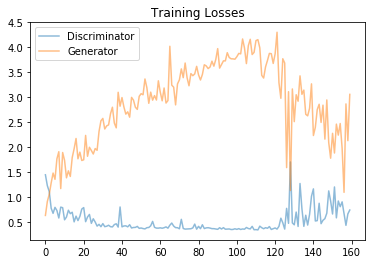

In [69]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [70]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [71]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

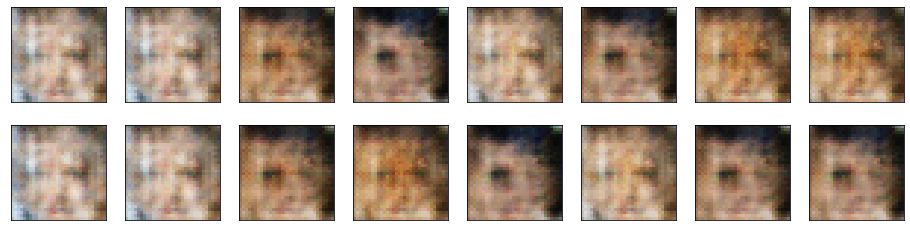

In [72]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.